# Train a regression ConvNN model using BOHB Hyperparameters

In [79]:
import sys  
sys.path.insert(0, '../../codes/')

from predict_observational_dataset_v2 import ProcessObservationalDataset
from train_regression import *
from bohb_optimizer_2 import *


In [6]:
# Libraries for BOHB Package 
import logging
logging.basicConfig(level=logging.WARNING)

import argparse

import hpbandster.core.nameserver as hpns
import hpbandster.core.result as hpres

from hpbandster.optimizers import BOHB as BOHB
from hpbandster.examples.commons import MyWorker

from tensorflow.keras.models import load_model
import ConfigSpace as CS
from hpbandster.core.worker import Worker

# Step 1: Load the dataset

In [7]:
# original dataset
df=pd.read_csv('../../datasets/browndwarf_R100_v4_newWL_v2.csv.bz2', compression='bz2')
df.head(3)

,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897,is_augmented
0,5.0,1100,0.25,-1.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
1,5.0,1100,0.25,-0.7,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
2,5.0,1100,0.25,-0.5,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no


In [8]:
wl = pd.read_csv('../../datasets/wl.csv')
wl.head(3)

,wl
0,2.511960
1,2.486966
2,2.462220


In [9]:
df.iloc[::10]

,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897,is_augmented
0,5.00,1100,0.25,-1.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
10,5.00,1100,0.25,1.7,8.540979e-09,9.610928e-09,8.362026e-09,6.331807e-09,5.411898e-09,3.597492e-09,...,2.589948e-09,1.400508e-09,1.423739e-09,1.331622e-09,5.718932e-10,2.525684e-09,2.577776e-09,2.171606e-09,1.170498e-09,no
20,5.00,1100,0.50,1.0,2.089233e-08,2.547443e-08,2.398659e-08,1.954245e-08,1.673706e-08,1.128757e-08,...,1.030422e-08,6.744711e-09,6.570654e-09,5.994584e-09,3.266539e-09,6.722988e-09,6.756289e-09,5.708415e-09,3.422240e-09,no
30,5.00,1100,1.00,0.5,3.773544e-08,4.306029e-08,3.789344e-08,2.982717e-08,2.555826e-08,1.704151e-08,...,3.370933e-08,2.475817e-08,2.292027e-08,2.084380e-08,1.293259e-08,1.818421e-08,1.723477e-08,1.401317e-08,8.880054e-09,no
40,5.00,1100,1.50,0.0,7.403044e-08,8.240733e-08,7.323895e-08,5.885655e-08,5.086389e-08,3.452053e-08,...,1.067845e-07,8.506743e-08,7.629151e-08,6.833675e-08,4.665959e-08,5.297000e-08,4.829532e-08,3.887601e-08,2.587082e-08,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30840,3.25,1000,1.00,-1.0,6.179704e-08,6.023661e-08,4.317990e-08,3.128656e-08,2.771920e-08,1.748527e-08,...,6.074206e-08,4.763676e-08,4.974581e-08,4.320090e-08,2.942153e-08,4.588604e-08,4.660016e-08,3.899730e-08,2.401752e-08,no
30850,3.25,1000,1.00,1.7,4.587650e-09,3.838308e-09,2.586146e-09,1.860407e-09,1.635306e-09,1.152218e-09,...,1.364340e-09,8.768095e-10,8.903187e-10,7.791423e-10,4.586279e-10,1.281345e-09,9.366753e-10,5.737637e-10,3.020979e-10,no
30860,3.25,1000,1.50,1.0,9.151923e-09,7.599074e-09,4.870096e-09,3.395405e-09,2.993091e-09,2.001870e-09,...,8.316857e-09,5.922216e-09,5.734787e-09,5.036230e-09,3.292385e-09,4.859911e-09,3.820969e-09,2.376922e-09,1.196810e-09,no
30870,3.25,1000,2.00,0.5,1.755109e-08,1.456820e-08,9.125922e-09,6.253583e-09,5.540055e-09,3.570220e-09,...,3.041929e-08,2.417082e-08,2.437794e-08,2.183006e-08,1.552078e-08,1.638151e-08,1.205167e-08,7.349473e-09,3.697040e-09,no


## Prepare feature variables (X) and targets (y)

In [10]:
df = df[df['is_augmented'].isin(['no'])]
X = df.drop(
    columns=['gravity', 
             'temperature', 
             'c_o_ratio', 
             'metallicity', 
             'is_augmented'])#.astype(np.float32)

y = df[['gravity', 'c_o_ratio', 'metallicity', 'temperature', ]]#.astype(np.float32)


In [11]:
y['temperature'] = np.log10(y['temperature'])

skewness:


{('c_o_ratio', 0.1577441958491052),
 ('gravity', 0.0),
 ('metallicity', 0.16546438330218305),
 ('temperature', -0.04214190742902561)}

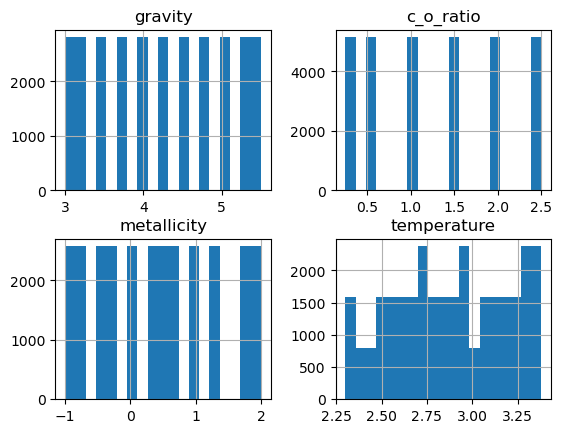

In [12]:
print( 'skewness:' )
display(set( zip(['gravity', 'c_o_ratio', 'metallicity', 'temperature'],(stats.skew(y[['gravity', 'c_o_ratio', 'metallicity', 'temperature', ]])))))
y.hist(grid=True, bins=19);

In [13]:
y.head()

,gravity,c_o_ratio,metallicity,temperature
0,5.0,0.25,-1.0,3.041393
1,5.0,0.25,-0.7,3.041393
2,5.0,0.25,-0.5,3.041393
3,5.0,0.25,-0.3,3.041393
4,5.0,0.25,0.0,3.041393


---

# Step 2: Data Processing

In [14]:
# Create an instance of TrainCNNRegression
train_cnn_regression = TrainRegression(feature_values=X,
                             feature_names=X.columns,
                             target_values=y.to_numpy(),
                             target_name=['gravity', 'c_o_ratio', 'metallicity', 'temperature'],
                             is_tuned='yes',
                             param_grid=None,
                             spectral_resolution=100,
                             is_feature_improved='no',
                             n_jobs=4,
                             cv=5,
                             is_augmented='no',
                             ml_model=None,
                             ml_model_str='CNN')

In [15]:
# Split the dataset into train and test sets
train_cnn_regression.split_train_validation_test(test_size=0.1, val_size=0.1)

In [16]:
# normalize the X features using MinMax Scaler
train_cnn_regression.normalize_X_row_wise()

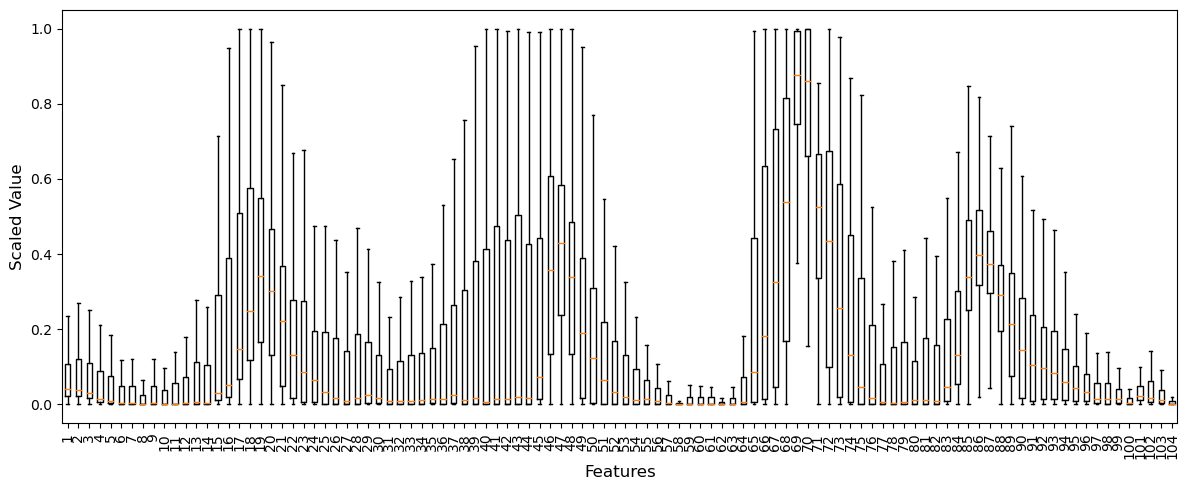

In [17]:
train_cnn_regression.plot_boxplot_scaled_features(train_cnn_regression.X_train_normalized_rowwise)

In [18]:
# Standardize the y features using Standard Scaler
train_cnn_regression.standardize_y_column_wise()

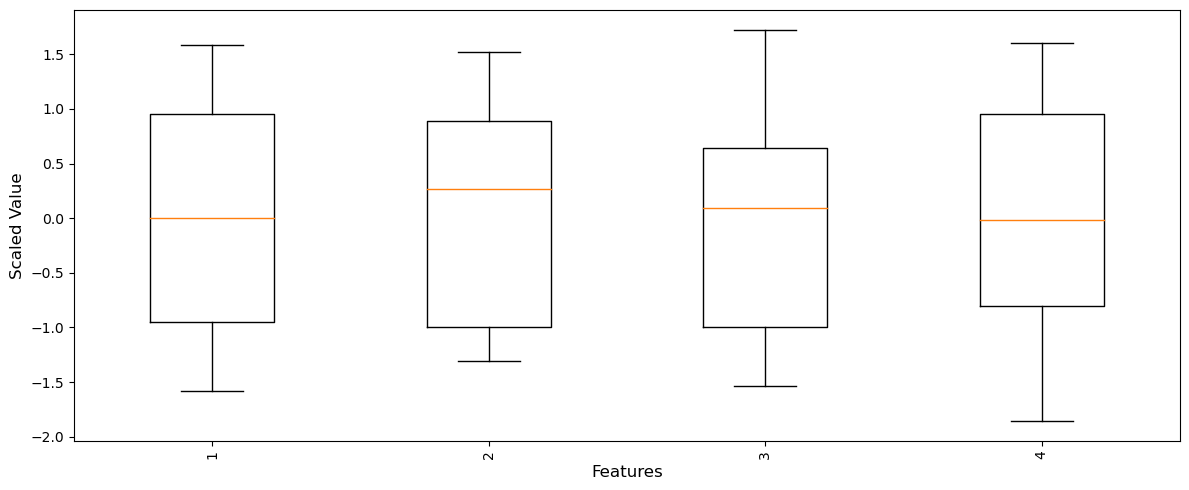

In [19]:
train_cnn_regression.plot_boxplot_scaled_features(train_cnn_regression.y_train_standardized_columnwise)

In [20]:
# train_cnn_regression.y_train_standardized_columnwise

In [21]:
train_cnn_regression.X_train_min = train_cnn_regression.X_train.min(axis=1)
train_cnn_regression.X_train_max = train_cnn_regression.X_train.max(axis=1)

In [22]:
train_cnn_regression.X_val_min = train_cnn_regression.X_val.min(axis=1)
train_cnn_regression.X_val_max = train_cnn_regression.X_val.max(axis=1)

In [23]:
train_cnn_regression.X_test_min = train_cnn_regression.X_test.min(axis=1)
train_cnn_regression.X_test_max = train_cnn_regression.X_test.max(axis=1)

In [24]:
df_MinMax_train = pd.DataFrame((train_cnn_regression.X_train_min, train_cnn_regression.X_train_max)).T
df_MinMax_val = pd.DataFrame((train_cnn_regression.X_val_min, train_cnn_regression.X_val_max)).T
df_MinMax_test = pd.DataFrame((train_cnn_regression.X_test_min, train_cnn_regression.X_test_max)).T

In [25]:
df_MinMax_train.rename(columns={0:'min', 1:'max'}, inplace=True)

In [26]:
df_MinMax_train

,min,max
28744,8.265340e-12,3.445259e-08
6288,8.080712e-22,8.397132e-14
13749,2.734403e-07,8.632182e-06
11713,4.414951e-16,3.373262e-10
15538,3.722576e-07,6.859888e-06
...,...,...
1806,3.537783e-10,2.404020e-07
10765,9.266921e-07,8.640541e-06
16472,3.583572e-12,1.047753e-07
27891,3.782887e-13,8.244911e-09


In [27]:
# plt.loglog(train_cnn_regression.X_train_max, 'k.', alpha = 0.4)
# plt.loglog(train_cnn_regression.X_train, 'r.', label='X_train', alpha = 0.4)
# plt.loglog(train_cnn_regression.X_train_min, 'r.', alpha = 0.4)

---

In [28]:
train_cnn_regression.standardize_X_column_wise(
                                                            X_train = df_MinMax_train.values,
                                                            X_val   = df_MinMax_val.values,
                                                            X_test  = df_MinMax_test.values,
                                                        )

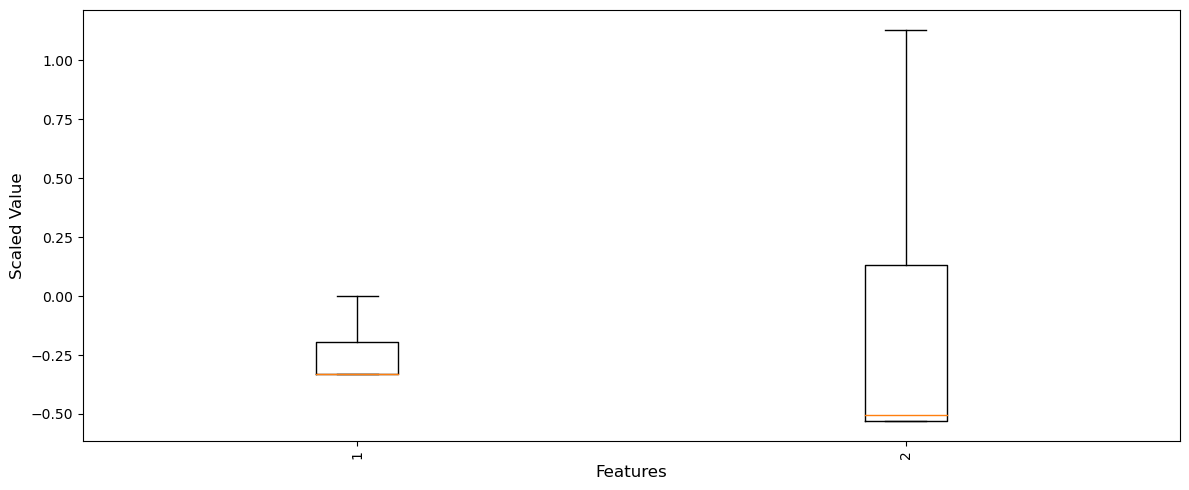

In [29]:
train_cnn_regression.plot_boxplot_scaled_features(train_cnn_regression.X_test_standardized_columnwise)

# Step 3: Train CNN model

In [30]:
# ===============================================================================
# ==================                                           ==================
# ==================            BOHB Optimizer                 ==================
# ==================                                           ==================
# ===============================================================================  




class KerasWorker(Worker):
    def __init__(self, 
                   X1_train, X1_val, X1_test, # Row-StandardScaled input spectra
                   X2_train, X2_val, X2_test, # Col-StandardScaled Mix Max of all rows of input spetra
                   y1_train, y1_val, y1_test, # Col-StandardScaled target feature 1
                   y2_train, y2_val, y2_test, # Col-StandardScaled target feature 2
                   y3_train, y3_val, y3_test, # Col-StandardScaled target feature 3
                   y4_train, y4_val, y4_test, # Col-StandardScaled target feature 4                 
                   *args, sleep_interval=0, **kwargs):

            super().__init__(**kwargs)
            self.sleep_interval = sleep_interval

            # self.batch_size = 2**9


            # train, val, test sets for input 1 (main 104 spectral features)
            self.X1_train, self.X1_val, self.X1_test = X1_train, X1_val, X1_test

            # train, val, test sets for input 2 (Min and Max 2 features)
            self.X2_train, self.X2_val, self.X2_test = X2_train, X2_val, X2_test
            
            # train, val, test sets for target features            
            self.y1_train, self.y1_val, self.y1_test = y1_train, y1_val, y1_test
            self.y2_train, self.y2_val, self.y2_test = y2_train, y2_val, y2_test
            self.y3_train, self.y3_val, self.y3_test = y3_train, y3_val, y3_test 
            self.y4_train, self.y4_val, self.y4_test = y4_train, y4_val, y4_test   


            # self.input_shape = (104,1)
            # print(np.shape(self.x_train), np.shape(self.y_train))




    def compute(self, config, budget, working_directory, *args, **kwargs):
        """
        Convolution Neural Networks to be optimized by BOHB package.
        The input parameter "config" (dictionary) contains the sampled configurations passed by the bohb optimizer
        """
        Conv__filters = config['Conv__filters']
        Conv__kernel_size = config['Conv__kernel_size']
        Conv__MaxPooling1D = config['Conv__MaxPooling1D']
        Conv__NumberLayers = config['Conv__NumberLayers']
        Conv__NumberBlocks = config['Conv__NumberBlocks']

        FC__units = config['FC__units']
        FC__units_temperature = config['FC__units_temperature']
        FC__units_c_o_ratio = config['FC__units_c_o_ratio']
        FC__units_gravity = config['FC__units_gravity']
        FC__units_metallicity = config['FC__units_metallicity']
        FC__NumberLayers = config['FC__NumberLayers']
        
        FC__dropout = config['FC__dropout']
        
        FC_out_dropout = config['FC_out_dropout']

        FC_in_Conv__units = config['FC_in_Conv__units']
        FC_in_Conv__dropout = config['FC_in_Conv__dropout']
        

        lr = config['lr']
        # LeakyReLU_alpha = config['LeakyReLU_alpha']
        # kernel_initializer_list = config['kernel_initializer_list']   
        

        ######### Shape of the inputs
        input_1 = tf.keras.layers.Input(shape=(104, 1))
        input_2 = tf.keras.layers.Input(shape=(2,))

        
        ######### Conv Blocks  ####################################
        model = input_1
        for b in range(0, Conv__NumberBlocks):
            for l in range(0, Conv__NumberLayers):
                model = Conv1D(filters = Conv__filters*(2)**b, 
                                  kernel_size = Conv__kernel_size, 
                                  strides = 1, 
                                  padding ='same', 
                                  activation = 'relu', 
                                  kernel_initializer = 'he_normal',
                                  # kernel_regularizer=tf.keras.regularizers.l2(Conv__regularizer),
                                  name = 'Conv__B'+str(b+1)+'_L'+str(l+1))(model) #(model if l != 0 and b != 0 else input_1)

            model = MaxPooling1D(pool_size=(Conv__MaxPooling1D),
                                name = 'MaxPooling1D__B'+str(b+1)+'_L'+str(l+1))(model)


        ######### Flatten Layer   ####################################
        model = Flatten()(model)


        ######### FC Layer before the Concatenation   ################
        model = Dense(FC_in_Conv__units, 
                                  activation = 'relu', 
                           kernel_initializer = 'he_normal',
                           # kernel_regularizer=tf.keras.regularizers.l2(Conv__regularizer),
                           name = 'FC_in_Conv__B'+str(1)+'_L'+str(1))(model)

        model= Dropout(FC_in_Conv__dropout, #### Have different Drop out here!!! 
                        name = 'FC_in_Conv__Dropout__B'+str(b+1)+'_L'+str(l+1))(model)
                
                
        ######### Concatenation Layer  ###############################
        # Concatenate the outputs from the convolutional layers and dense layer
        model = tf.keras.layers.concatenate([model, input_2], 
                                                           name='Concatenated_Layer')

        ######### FC Block  ####################################
        for b in range(1): # We need 1 Blocks
            for l in range(FC__NumberLayers): # We can have multiple layers
                model = Dense(FC__units, 
                                  activation = 'relu', 
                           kernel_initializer = 'he_normal',
                           # kernel_regularizer=tf.keras.regularizers.l2(Conv__regularizer),
                           name = 'FC__B'+str(b+1)+'_L'+str(l+1))(model)

                model= Dropout(FC__dropout, 
                                       name = 'FC__Dropout__B'+str(b+1)+'_L'+str(l+1))(model)
        
        

        ######### 3rd FC Block: gravity  ##############################
    #         FC2 = FC__Drop

        model2 = Dense(FC__units_gravity, 
                                  activation = 'relu', 
                        kernel_initializer = 'he_normal',
                        # kernel_regularizer=tf.keras.regularizers.l2(0.003/2),
                        name = 'FC_block3_gravity')(model)
        
        model2= Dropout(FC_out_dropout, 
                               name = 'FC_block3_gravity__Dropout')(model2)
        
        out__gravity = Dense(1, 
                             activation = 'linear',
                             kernel_initializer = 'he_normal',
                             name = 'gravity')(model2)
        

        
        ######### 3rd FC Block: c_o_ratio  ##############################
        model2 = Dense(FC__units_c_o_ratio, 
                                  activation = 'relu', 
                        kernel_initializer = 'he_normal',
                        # kernel_regularizer=tf.keras.regularizers.l2(0.003/2),
                        name = 'FC_block3_c_o_ratio')(model)
        
        model2= Dropout(FC_out_dropout, 
                               name = 'FC_block3_c_o_ratio__Dropout')(model2)


        out__c_o_ratio = Dense(1, 
                               activation = 'linear',
                               kernel_initializer = 'he_normal',
                               # kernel_regularizer=tf.keras.regularizers.l2(0.003/2),
                               name='c_o_ratio')(model2)

        
        ######### 3rd FC Block: metallicity  ##############################
        model2 = Dense(FC__units_metallicity, 
                                  activation = 'relu', 
                        kernel_initializer = 'he_normal',
                        # kernel_regularizer=tf.keras.regularizers.l2(0.003/2),
                        name = 'FC_block3_metallicity')(model)
        
        model2= Dropout(FC_out_dropout, 
                               name = 'FC_block3_metallicity__Dropout')(model2)

        
        out__metallicity = Dense(1, 
                                 activation = 'linear',
                                 kernel_initializer = 'he_normal',
                                 name='metallicity')(model2)
        
        
        
        ######### 3rd FC Block: temperature  ##############################
        model2 = Dense(FC__units_temperature, 
                                  activation = 'relu', 
                        kernel_initializer = 'he_normal',
                        # kernel_regularizer=tf.keras.regularizers.l2(0.003/2),
                        name = 'FC_block3_temperature')(model)
        
        model2= Dropout(FC_out_dropout, 
                               name = 'FC_block3_temperature__Dropout')(model2)
        

        out__temperature = Dense(1, 
                                 activation = 'linear',
                                 name='temperature')(model2)


        ######### OUTPUT   ################################################
        # Create the model with two inputs and two outputs
        model = tf.keras.Model(inputs=[input_1, input_2], 
                               outputs=[out__gravity, out__c_o_ratio, out__metallicity, out__temperature])

        # Compile the model with an optimizer, loss function, and metrics
        model.compile(loss='huber_loss', 
                      optimizer=keras.optimizers.Adam(lr = lr),  
                      metrics=['mae'])
        
        
        
 

  
        early_stop = EarlyStopping(monitor='loss', min_delta=4e-4, patience=50, mode='auto', \
                                       restore_best_weights=True)



        # YOU CAN ADD FUNCTION HERE TO ADD NOISE
        history = model.fit(x = [self.X1_train, self.X2_train], 
                            y = [self.y1_train, self.y2_train, self.y3_train, self.y4_train],  #self.x_train, self.y_train,
                          batch_size = 32, #config['batch_size'], # self.batch_size,
                          validation_data=([self.X1_val, self.X2_val], [self.y1_val, self.y2_val, self.y3_val, self.y4_val]),
                          #validation_split=0.2,
                          epochs=int(budget),
                          verbose=1,
                          callbacks=[early_stop],
                 )


        train_score = model.evaluate(x = [self.X1_train, self.X2_train], 
                                     y = [self.y1_train, self.y2_train, self.y3_train, self.y4_train],
                                     verbose=0)
        val_score   = model.evaluate(x = [self.X1_val, self.X2_val], 
                                     y = [self.y1_val, self.y2_val, self.y3_val, self.y4_val],
                                     verbose=0)
        test_score  = model.evaluate(x = [self.X1_test, self.X2_test], 
                                     y = [self.y1_test, self.y2_test, self.y3_test, self.y4_test],
                                     verbose=0)

        #print(train_score, val_score, test_score)
#             #import IPython; IPython.embed()
        return ({
                'loss': val_score[1], # remember: HpBandSter always minimizes!
                'info': {       'test accuracy': test_score[1],
                                        'train accuracy': train_score[1],
                                        'validation accuracy': val_score[1],
                                        'number of parameters': model.count_params(),
                                },
                'model' : model,
                'history' : history,

        })

    @staticmethod
    def get_configspace():
        """
        It builds the configuration space with the needed hyperparameters.
        It is easily possible to implement different types of hyperparameters.
        Beside float-hyperparameters on a log scale, it is also able to handle categorical input parameter.
        :return: ConfigurationsSpace-Object
        """
        cs = CS.ConfigurationSpace()


       

        # Conv hyperparameters
        Conv__filters = CategoricalHyperparameter(name='Conv__filters', choices=[4 , 8, 16, 32]) # NOTE: Apply the same categorical method for other unit and 
        Conv__kernel_size = UniformIntegerHyperparameter(name='Conv__kernel_size', lower=1, upper=8, default_value=1,  log=False) # ok
        Conv__MaxPooling1D = UniformIntegerHyperparameter(name='Conv__MaxPooling1D', lower=1, upper=8, default_value=1, log=False) # ok
        Conv__NumberLayers = UniformIntegerHyperparameter(name='Conv__NumberLayers', lower=1, upper=6, default_value=1,  log=False) # ok
        Conv__NumberBlocks =  UniformIntegerHyperparameter(name='Conv__NumberBlocks', lower=1, upper=4, default_value=1,  log=False) # ok

        # FC hyperparameters
        FC__units = CategoricalHyperparameter(name='FC__units', choices=[8, 16, 32 , 64, 128, 256]) # NOTE: Apply the same categorical method for other unit and 

        FC__units_temperature = CategoricalHyperparameter(name='FC__units_temperature', choices=[8, 16, 32 , 64, 128, 256]) # the same
        FC__units_metallicity = CategoricalHyperparameter(name='FC__units_metallicity', choices=[8, 16, 32 , 64, 128, 256]) # the same
        FC__units_c_o_ratio = CategoricalHyperparameter(name='FC__units_c_o_ratio', choices=[8, 16, 32 , 64, 128, 256]) # the same
        FC__units_gravity = CategoricalHyperparameter(name='FC__units_gravity', choices=[8, 16, 32 , 64, 128, 256]) # same

        FC__NumberLayers = UniformIntegerHyperparameter(name='FC__NumberLayers', lower=1, upper=5, default_value=1,  log=False) 
        # FC__NumberBlocks = UniformIntegerHyperparameter(name='FC__NumberBlocks', lower=1, upper=5, default_value=1,  log=False) # DELETE - No blocks for FC
        FC__dropout = UniformFloatHyperparameter(name='FC__dropout', lower=0.001, upper=0.4, default_value=0.02, log=True)
        FC_out_dropout = UniformFloatHyperparameter(name='FC_out_dropout', lower=0.001, upper=0.4, default_value=0.02, log=True)
        
        FC_in_Conv__units = CategoricalHyperparameter(name='FC_in_Conv__units', choices=[8, 16, 32 , 64, 128, 256]) # same
        #FC_in_Conv__NumberBlocks = UniformIntegerHyperparameter(name='FC_in_Conv__NumberBlocks', lower=1, upper=5, default_value=1,  log=False) ## DELETE, 
        #FC_in_Conv__NumberLayers = UniformIntegerHyperparameter(name='FC_in_Conv__NumberLayers', lower=1, upper=5, default_value=1,  log=False) ### DELETE
        FC_in_Conv__dropout = UniformFloatHyperparameter(name='FC_in_Conv__dropout', lower=0.001, upper=0.4, default_value=0.02, log=True)
        
        # Other hyperparameters
        lr = UniformFloatHyperparameter(name='lr', lower=1e-5, upper=1e-2, default_value=1e-4, log=True)
        #LeakyReLU_alpha = UniformFloatHyperparameter(name='LeakyReLU_alpha', lower=0.01, upper=0.3, default_value=0.01, log=True) ## RELU
        #kernel_initializer_list = CategoricalHyperparameter(name='kernel_initializer_list', choices=['he_normal', 'glorot_uniform']) ## CHECK

        # Optimize size
        # kernel_regularizer = Default
        # MaxPooling1D: 
        # Gaus = keras.layers.GaussianNoise(0.01,)(input_1)
   
        
        cs.add_hyperparameters([
                                Conv__filters,
                                Conv__kernel_size,
                                Conv__MaxPooling1D,
                                Conv__NumberLayers,
                                Conv__NumberBlocks,
            
                                FC__units,
                                FC__units_temperature,
                                FC__units_c_o_ratio,
                                FC__units_gravity,
                                FC__units_metallicity,
                                FC__NumberLayers,
                                FC__dropout,
                                FC_out_dropout,
            
                                FC_in_Conv__units,
                                FC_in_Conv__dropout,
            
                                lr,
                               ]) 
        
        
        return cs

In [31]:
w = KerasWorker(
            # input dataset: StandardScaled instances  
            X1_train = train_cnn_regression.X_train_normalized_rowwise,
            X1_val   = train_cnn_regression.X_val_normalized_rowwise,
            X1_test  = train_cnn_regression.X_test_normalized_rowwise,

            # input dataset: Min Max of each instance  
            X2_train = train_cnn_regression.X_train_standardized_columnwise,
            X2_val   = train_cnn_regression.X_val_standardized_columnwise,
            X2_test  = train_cnn_regression.X_test_standardized_columnwise,

            # 1st target
            y1_train = train_cnn_regression.y_train_standardized_columnwise[:,0],
            y1_val   = train_cnn_regression.y_val_standardized_columnwise[:,0],
            y1_test  = train_cnn_regression.y_test_standardized_columnwise[:,0],

            # 2nd target
            y2_train = train_cnn_regression.y_train_standardized_columnwise[:,1],
            y2_val   = train_cnn_regression.y_val_standardized_columnwise[:,1],
            y2_test  = train_cnn_regression.y_test_standardized_columnwise[:,1],

            # 3rd target
            y3_train = train_cnn_regression.y_train_standardized_columnwise[:,2],
            y3_val   = train_cnn_regression.y_val_standardized_columnwise[:,2],
            y3_test  = train_cnn_regression.y_test_standardized_columnwise[:,2],

            # 4th target
            y4_train = train_cnn_regression.y_train_standardized_columnwise[:,3],
            y4_val   = train_cnn_regression.y_val_standardized_columnwise[:,3],
            y4_test  = train_cnn_regression.y_test_standardized_columnwise[:,3],



            run_id='0')


In [32]:
config =  {'Conv__MaxPooling1D': 4,
 'Conv__NumberBlocks': 1,
 'Conv__NumberLayers': 3,
 'Conv__filters': 16,
 'Conv__kernel_size': 7,
 'FC__NumberLayers': 2,
 'FC__dropout': 0.012265676546186943,
 'FC__units': 256,
 'FC__units_c_o_ratio': 32,
 'FC__units_gravity': 8,
 'FC__units_metallicity': 64,
 'FC__units_temperature': 128,
 'FC_in_Conv__dropout': 0.006019453739459596,
 'FC_in_Conv__units': 256,
 'FC_out_dropout': 0.009157502921601706,
 'lr': 0.00022569322010206787}

In [33]:
trained_cnn_model =  trained_cnn_model = w.compute(config = config, 
                                                   budget = 50, 
                                                   working_directory='../../outputs/regression/BOHB/4/')

2023-06-14 14:24:03.324875: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 14:24:03.331597: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/50
782/782 [==============================] - 77s 97ms/step - loss: 0.4230 - gravity_loss: 0.1680 - c_o_ratio_loss: 0.1088 - metallicity_loss: 0.1250 - temperature_loss: 0.0213 - gravity_mae: 0.4510 - c_o_ratio_mae: 0.3511 - metallicity_mae: 0.3946 - temperature_mae: 0.1352 - val_loss: 0.1911 - val_gravity_loss: 0.0547 - val_c_o_ratio_loss: 0.0507 - val_metallicity_loss: 0.0829 - val_temperature_loss: 0.0027 - val_gravity_mae: 0.2473 - val_c_o_ratio_mae: 0.2442 - val_metallicity_mae: 0.3216 - val_temperature_mae: 0.0552
Epoch 2/50
782/782 [==============================] - 71s 91ms/step - loss: 0.1674 - gravity_loss: 0.0567 - c_o_ratio_loss: 0.0385 - metallicity_loss: 0.0669 - temperature_loss: 0.0053 - gravity_mae: 0.2504 - c_o_ratio_mae: 0.2075 - metallicity_mae: 0.2883 - temperature_mae: 0.0788 - val_loss: 0.1097 - val_gravity_loss: 0.0297 - val_c_o_ratio_loss: 0.0256 - val_metallicity_loss: 0.0527 - val_temperature_loss: 0.0017 - val_gravity_mae: 0.1814 - val_c_o_ratio_mae:

In [34]:
trained_cnn_model

{'loss': 0.008051264099776745,
 'info': {'test accuracy': 0.010814552195370197,
  'train accuracy': 0.010256977751851082,
  'validation accuracy': 0.008051264099776745,
  'number of parameters': 302452},
 'model': <keras.engine.functional.Functional at 0x7f80c53b0910>,
 'history': <keras.callbacks.History at 0x7f80c5896cd0>}

In [35]:
train_cnn_regression.trained_model = trained_cnn_model['model']

# Save Trained Model

In [80]:
train_cnn_regression.trained_model.save('../../outputs/regression/trained_models/my_model_architecture__xNorm_yStand_MinMax.h5')
train_cnn_regression.trained_model.save_weights('../../outputs/regression/trained_models/my_model_weights__xNorm_yStand_MinMax.h5')

with open('../../outputs/regression/trained_models/training_history__xNorm_yStand_MinMax.pkl', 'wb') as file:
    pk.dump(trained_cnn_model['history'], file)
    


# Load Saved Models

In [37]:
model = load_model('not_used5/my_model_architecture__xNormGlobal_yStand.h5')
model.load_weights('../../outputs/regression/trained_models/my_model_weights__xNorm_yStand_MinMax_v20.h5')

# Loading the saved history object
with open('../../outputs/regression/trained_models/training_history__xNorm_yStand_MinMax_v20.pkl', 'rb') as file:
    history = pk.load(file)    

In [38]:
train_cnn_regression.trained_model = model
train_cnn_regression.trained_model_history = history

---

# Step 3: Check Trained Model

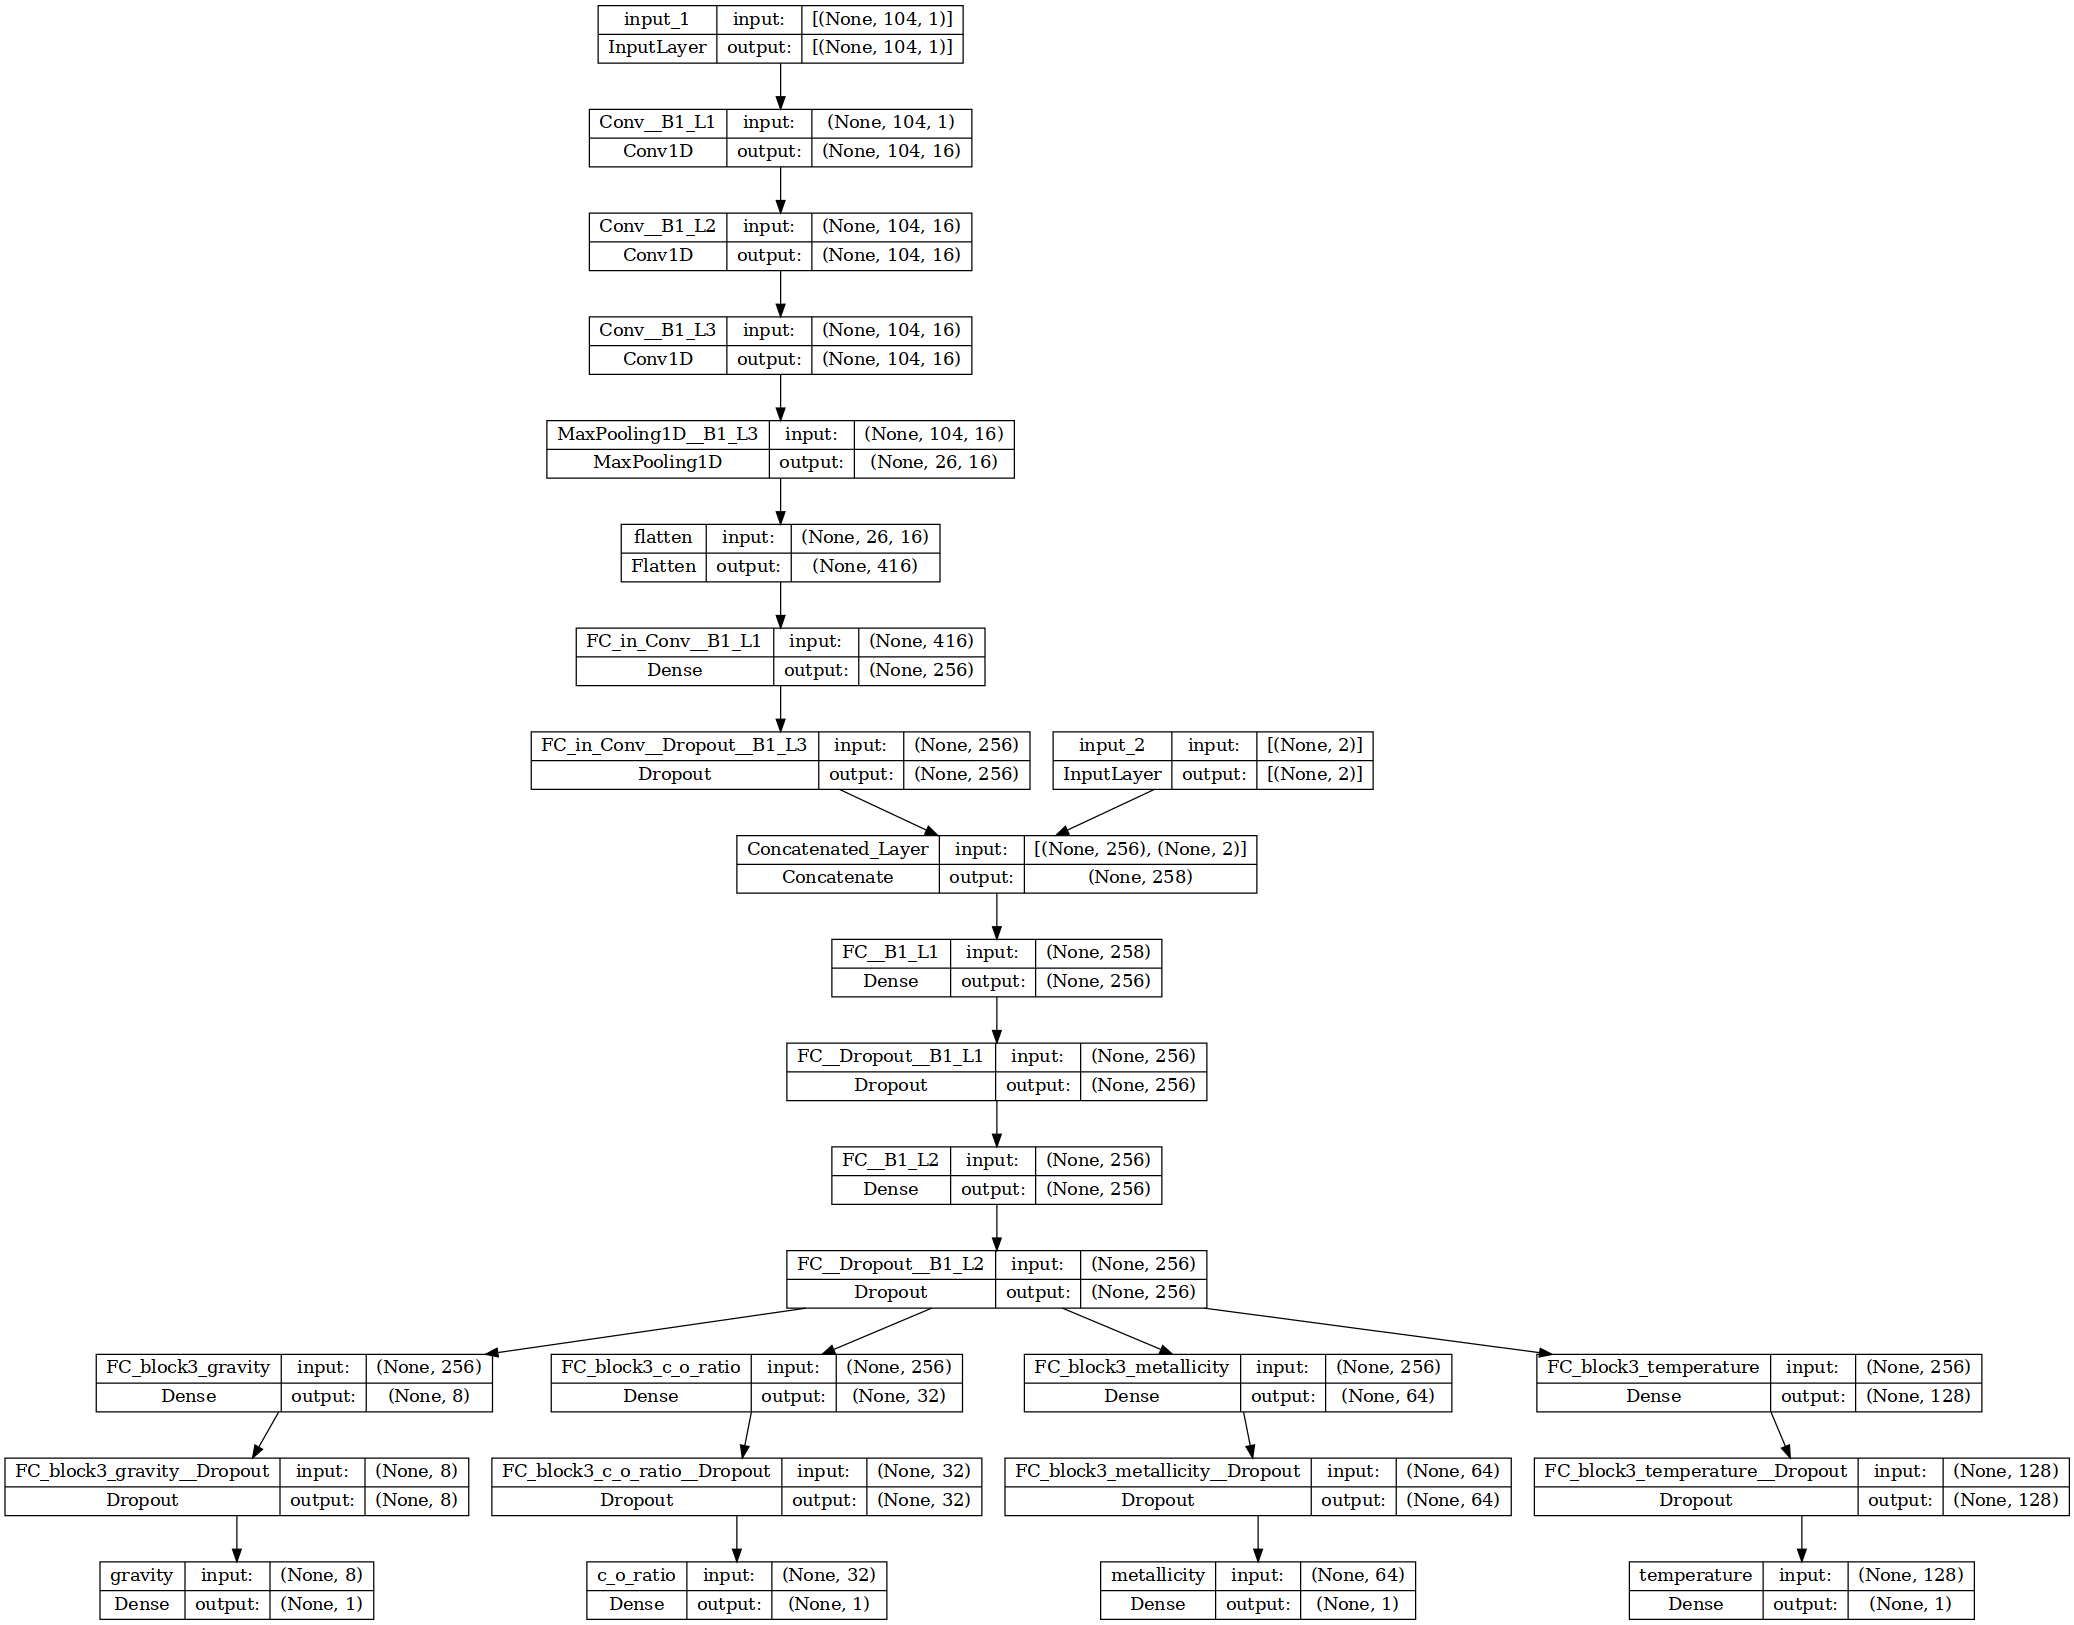

In [39]:
tf.keras.utils.plot_model(
                train_cnn_regression.trained_model,
                to_file="model.png",
                show_shapes=True,
                show_dtype=False,
                show_layer_names=True,
                rankdir="TB",
                expand_nested=True,
                dpi=90,
                layer_range=None,
                show_layer_activations=False,
)

In [40]:
train_cnn_regression.trained_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 104, 1)]     0           []                               
                                                                                                  
 Conv__B1_L1 (Conv1D)           (None, 104, 16)      128         ['input_1[0][0]']                
                                                                                                  
 Conv__B1_L2 (Conv1D)           (None, 104, 16)      1808        ['Conv__B1_L1[0][0]']            
                                                                                                  
 Conv__B1_L3 (Conv1D)           (None, 104, 16)      1808        ['Conv__B1_L2[0][0]']            
                                                                                              

In [41]:
train_cnn_regression.plot_model_loss(title = 'X:NormRow, y:StandCol - MinMax:StandCol')

### Print outputs

In [42]:
# import pprint 
# pp = pprint.PrettyPrinter(indent=4)
# pp.pprint(trained_cnn_model)

In [43]:
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, explained_variance_score

from scipy import stats
import seaborn as sns

def regression_report(trained_model, 
                      Xtrain, 
                      Xtest, 
                      ytrain, 
                      ytest,
                      target_i,
                          xy_top = [0.55, 0.85],
                          xy_bottom = [0.05, 0.8],
                          print_results = True):
    
    y_pred_train = np.array(trained_model.trained_model.predict(Xtrain) )[:,:,0].T
    y_pred_train_list = trained_model.standardize_y_ColumnWise.inverse_transform( y_pred_train )
    y_pred_train_list [:,3] = 10**y_pred_train_list[:,3]

    y_act_train_list = trained_model.standardize_y_ColumnWise.inverse_transform( ytrain )
    y_act_train_list [:,3] = 10**y_act_train_list[:,3]

    y_pred_test = np.array(trained_model.trained_model.predict(Xtest))[:,:,0].T
    y_pred_test_list = trained_model.standardize_y_ColumnWise.inverse_transform(y_pred_test)
    y_pred_test_list[:,3] = 10**y_pred_test_list[:,3]

    y_act_test_list = trained_model.standardize_y_ColumnWise.inverse_transform(ytest)
    y_act_test_list[:,3] = 10**y_act_test_list[:,3]

    
    
    for i in range(0,target_i):
        y_pred_train = y_pred_train_list[:,i]
        y_act_train = y_act_train_list[:,i]
            
        y_pred_test = y_pred_test_list[:,i]
        y_act_test = y_act_test_list[:,i]

            
        
        residual_train_list = y_pred_train - y_act_train
        residual_test_list = y_pred_test - y_act_test


        f, axs = plt.subplots(2,1,
                            figsize=(5,5),
                            sharey=False,
                            sharex=False,
                            gridspec_kw=dict(height_ratios=[1,3])
                            )

        r2_score_train = r2_score(y_pred_train , y_act_train)
        r2_score_test = r2_score(y_pred_test , y_act_test)

        rmse_score_train = np.sqrt( mean_squared_error(y_pred_train , y_act_train) )
        rmse_score_test = np.sqrt( mean_squared_error(y_pred_test , y_act_test) )

    #     print(mean_squared_error(y_pred_train[:,target_i] , ytrain[:,target_i]))

        mean_test = np.round(np.mean(residual_test_list),2)
        std_test = np.round(np.std(residual_test_list),2)
        mean_train = np.round(np.mean(residual_train_list),2)
        std_train = np.round(np.std(residual_train_list),2)



        skew_test = stats.skew(residual_test_list)
        skew_train = stats.skew(residual_train_list)

        if print:
            print('\n\n----------------------- Test ------------------------')
            print('R2: {:2.2f} \t  RMSE: {:2.2f} \t Mean+/-STD: {:2.2f}+/-{:2.2f}'.format(r2_score_test, rmse_score_train, mean_test, std_test))

            print('\n----------------------- Train ------------------------')
            print('R2: {:2.2f} \t  RMSE: {:2.2f} \t Mean+/-STD: {:2.2f}+/-{:2.2f}'.format(r2_score_train, rmse_score_test, mean_train, std_train))
            # print(' r2_score, rmse_score_test')
            # print(r2_score_train, rmse_score_train)
            # print('------ mean, std -----------')
            # print( mean_train, std_train)
            # print('------- Skewness -----------')
            # print(skew_train)
            # print('------------------\n\n\n')

        axs[0].set_title(['Gravity','C_O_ratio', 'Metallicity', 'Temperature'][i],fontsize = 14)

        sns.histplot(data= residual_train_list, 
                    ax=axs[0],
                    label='train', 
                    alpha = 0.7, bins=19, log_scale=False, stat='percent', legend=True, linewidth=0
                    )

        sns.histplot(data= residual_test_list, 
                    label='test', 
                    ax=axs[0],
                    alpha = 0.3, bins=19, stat='percent', legend=True,linewidth=0
                )

        axs[0].set_xlim((-(abs(mean_train)+3*std_train),(abs(mean_train)+3*std_train)))
        axs[0].set_ylim((1e-1,100))
        axs[0].set_yscale('log')
        axs[0].set_ylabel('Probability %', fontsize = 12)

        # yact = cnn_model.StandardScaler_column_y.inverse_transform(  np.array(ytrain))[:,target_i]
        # ypred = cnn_model.StandardScaler_column_y.inverse_transform(  np.array(cnn_model.trained_model.predict(Xtrain))[:,:,0].T )[:,target_i]
        sns.scatterplot(
                    y = y_pred_train,
                    x = y_act_train,
                    label='train', 
                    ax=axs[1],
                    alpha = 0.7, 
                    legend=False,
                    )

        # yact = cnn_model.StandardScaler_column_y.inverse_transform(  np.array(ytest))[:,target_i]
        # ypred = cnn_model.StandardScaler_column_y.inverse_transform(  np.array(cnn_model.trained_model.predict(Xtest))[:,:,0].T )[:,target_i]
        sns.scatterplot(
                    y = y_pred_test,
                    x = y_act_test,
                    label = 'test', 
                    ax = axs[1],
                    alpha = 0.7, legend=False,
                    )
        # axs[1].set_xlim((min(y_pred_train),max(y_pred_train)))



        axs[1].set_ylabel('Predicted value', fontsize = 12)
        axs[1].set_xlabel('Actual value', fontsize = 12)


        axs[0].annotate(r'$\tilde{\mu}_{{\rm 3, train}}$= '+f'{np.round(skew_train,2)}', 
                            fontsize=11, xy=(xy_top[0],xy_top[1]+0.08), xycoords='axes fraction')
        axs[0].annotate(r'$\tilde{\mu}_{{\rm 3, test}}$ = '+f'{np.round(skew_test,2)}', 
                            fontsize=11, xy=(xy_top[0],xy_top[1]-0.08), xycoords='axes fraction')

        axs[1].annotate(r'R$^2_{\rm train}$='+f'{"%0.2f"%r2_score_train} [{"%0.2f"%abs(mean_train)}$\pm${"%0.2f"%std_train}]', 
                            fontsize=11, xy=(xy_bottom[0],xy_bottom[1]+0.06), xycoords='axes fraction')
        axs[1].annotate(r'R$^2_{\rm test}$ ='+f'{np.round(r2_score_test,2)} [{"%0.2f"%mean_test}$\pm${"%0.2f"%std_test}]',
                            fontsize=11, xy=(xy_bottom[0],xy_bottom[1]-0.06), xycoords='axes fraction')





        axs[1].legend(loc='lower right', fontsize = 11)
        # plt.yscale('log')

        f.tight_layout()
        plt.show()

97/97 [==============================] - 2s 17ms/step


----------------------- Test ------------------------
R2: 0.98 	  RMSE: 0.12 	 Mean+/-STD: 0.01+/-0.12

----------------------- Train ------------------------
R2: 0.98 	  RMSE: 0.12 	 Mean+/-STD: 0.01+/-0.12


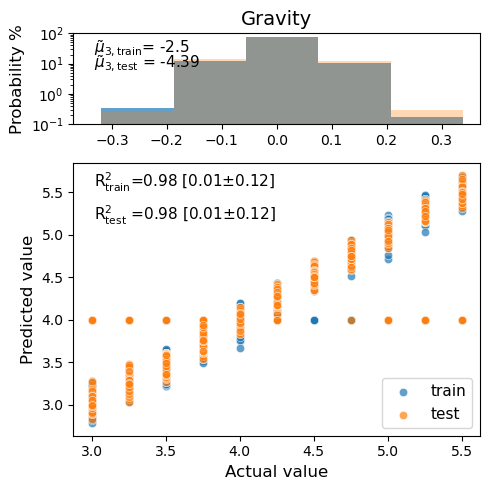



----------------------- Test ------------------------
R2: 0.97 	  RMSE: 0.13 	 Mean+/-STD: -0.00+/-0.13

----------------------- Train ------------------------
R2: 0.97 	  RMSE: 0.13 	 Mean+/-STD: -0.00+/-0.13


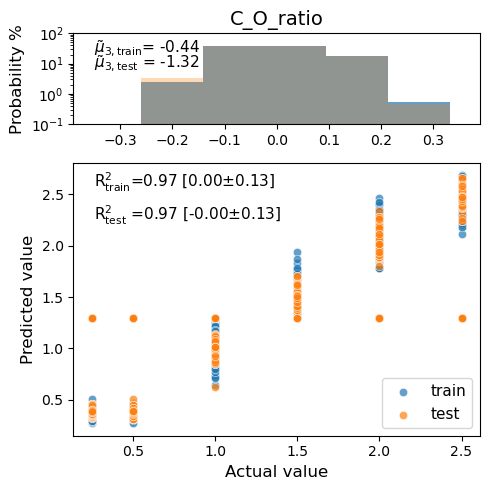



----------------------- Test ------------------------
R2: 0.92 	  RMSE: 0.25 	 Mean+/-STD: 0.01+/-0.25

----------------------- Train ------------------------
R2: 0.92 	  RMSE: 0.25 	 Mean+/-STD: 0.02+/-0.25


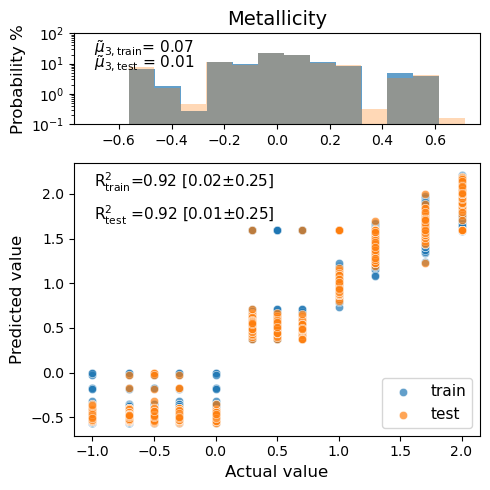



----------------------- Test ------------------------
R2: 1.00 	  RMSE: 19.75 	 Mean+/-STD: 4.35+/-21.53

----------------------- Train ------------------------
R2: 1.00 	  RMSE: 21.97 	 Mean+/-STD: 3.93+/-19.36


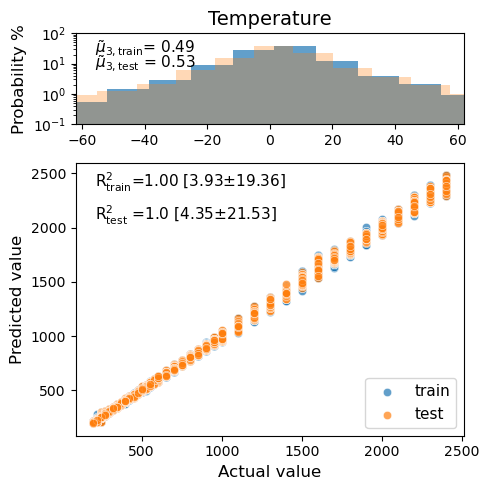

In [44]:
i = 1
regression_report(
        trained_model = train_cnn_regression,
    
        Xtrain = [train_cnn_regression.X_train_normalized_rowwise[::i],
                  train_cnn_regression.X_train_standardized_columnwise[::i]],
    
        Xtest  = [train_cnn_regression.X_test_normalized_rowwise[::i], 
                  train_cnn_regression.X_test_standardized_columnwise[::i]],
    
        ytrain = train_cnn_regression.y_train_standardized_columnwise[::i],
    
        ytest  = train_cnn_regression.y_test_standardized_columnwise[::i],
    
        target_i = 4,
        
        xy_top   = [0.05, 0.7],
        xy_bottom= [0.05, 0.85],
        print_results = False,        
                 )

# Step 4: Predict Observational data using the trained model

In [45]:
fluxcal = pd.read_csv(f'../../datasets/observational_spectra/GJ570D_fluxcal.dat', 
                   delim_whitespace=True, comment='#', names=('wl','F_lambda','F_lambda_error'), 
                   usecols=(0,1,2))#.dropna(inplace=True)

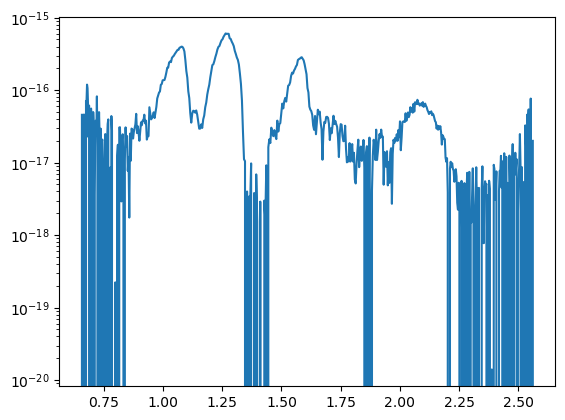

In [46]:
plt.semilogy( fluxcal['wl'],fluxcal['F_lambda'])

In [47]:
fluxcal['F_lambda']=fluxcal['F_lambda'].mask(fluxcal['F_lambda'].lt(0),0)
fluxcal['F_lambda'].replace(0, np.nan, inplace=True)
fluxcal['F_lambda'].interpolate(inplace=True)

In [48]:
bd_object = ProcessObservationalDataset( feature_values_obs = fluxcal['F_lambda'].values,
                                 feature_names_obs  = fluxcal['wl'].values, 
                                 feature_names_synthetic = wl['wl'].values,
                                )

object_name = 'GJ570D'
# add the BD derived values: name, Teff, logg, met, distance_pc, radius_Rjup
if object_name == 'Ross458C':
    bd_object.bd_info('Ross458C','804','4.09','0.23', 11.509, 0.68 )
if object_name == 'HD3651B':
    bd_object.bd_info('HD3651B','818','3.94','-0.22', 11.134, 0.81 )
if object_name == 'GJ570D':
    bd_object.bd_info('GJ570D','818','3.94','-0.22', 5.884, 0.79 )    




bd_object.flux_interpolated(print_results=False, 
                            plot_results=True,
                            use_spectres=True
                           )
bd_object.df_flux_object     

# print(bd_object.df_flux_object[::-1] )

,0.897,0.906,0.915,0.924,0.933,0.943,0.952,0.962,0.971,0.981,...,2.296,2.319,2.342,2.366,2.389,2.413,2.438,2.462,2.487,2.512
0,7.280711e-09,8.611113e-09,1.062637e-08,1.170489e-08,7.329417e-09,1.371097e-08,1.299396e-08,1.443783e-08,1.943760e-08,2.911763e-08,...,7.612835e-09,6.693866e-09,8.187037e-09,8.760881e-09,8.572828e-09,1.231363e-08,1.863393e-08,1.684466e-08,2.206102e-08,1.915624e-08


In [49]:
bd_object.df_flux_object_min = bd_object.df_flux_object.min(axis=1)
bd_object.df_flux_object_max = bd_object.df_flux_object.max(axis=1)

df_MinMax_obs = pd.DataFrame(( bd_object.df_flux_object_min, bd_object.df_flux_object_max)).T

xxx2 = train_cnn_regression.standardize_X_ColumnWise.transform(df_MinMax_obs.values)


In [50]:
X_std = (bd_object.df_flux_object.values[0] - bd_object.df_flux_object.min(axis=1)[0]) / (bd_object.df_flux_object.max(axis=1)[0] - bd_object.df_flux_object.min(axis=1)[0])
X_scaled = X_std * (1. - 0.) + 0.

In [51]:
X_scaled = X_scaled[::-1].reshape(1,104)

In [52]:
y_pred_train = np.array(train_cnn_regression.trained_model.predict([X_scaled,xxx2]) )[:,:,0].T
y_pred_train_ = train_cnn_regression.standardize_y_ColumnWise.inverse_transform( y_pred_train )
y_pred_train_ [:,3] = 10**y_pred_train_[:,3]
y_pred = y_pred_train_

1/1 [==============================] - 0s 89ms/step


In [53]:
y_pred

array([[ 5.3323107e+00,  1.4882171e+00, -4.5183232e-01,  8.1353961e+02]],
      dtype=float32)

In [56]:
import pandas as pd
import numpy as np
nearest_value_list = []

def filter_dataframe(df, targets):
    # Check if the values exist in the respective columns
    for col, value in targets.items():
        if value not in df[col].values:
            # Find the nearest values in the column
            nearest_value = df[col].values[np.argmin(np.abs(df[col].values - value))]
            print(nearest_value)
            targets[col] = nearest_value
            nearest_value_list.append(nearest_value)

    # Filter the DataFrame based on the values
    filtered_df = df
    for col, value in targets.items():
        filtered_df = filtered_df[filtered_df[col] == value]

    return nearest_value_list, filtered_df

# Print the filtered DataFrame

# Filter the DataFrame and get the result
# nearest_value1, filtered_df1 = filter_dataframe(df, targets)
# display(filtered_df1)


#### ====================================================================================================
#### ====================================================================================================
#### ====================================================================================================
#### ====================================================================================================
#### ====================================================================================================

# Specify target values
# Create the figure


def plot_predicted_vs_observed(data = df, 
                               targets = targets,
                               object_name = 'GJ570D',):
    
    nearest_value1, filtered_df1 = filter_dataframe(data, targets)

    p = figure(title=f'{object_name} [XNorm, yStand] Predicted: '+', '.join([['logg= ','C/O= ', 'Met= ', 'T= '][i]+str(np.round(y_pred[0][i],2)) for i in  range(4)]), 
               x_axis_label='features [wavelengths]', 
               y_axis_label='Flux (Fν)',
               width=1000, height=300,
               y_axis_type = 'log')

    # Add the scatter plot
    p.line(x =wl['wl'] , y=filtered_df1.iloc[:,4:-1].values[0], 
           line_width = 1,
           legend_label='Modeled:'+', '.join([['logg= ','C/O= ', 'Met= ', 'T= '][i]+str(np.round(nearest_value1[i],2)) for i in  range(4)]))
    p.circle(x = wl['wl'] , y=filtered_df1.iloc[:,4:-1].values[0],
           line_width = 2,
           # legend_label='Observation'
            )



    p.line(x =wl['wl'] , y=bd_object.df_flux_object.iloc[:, ::-1].values[0],
           line_color = 'orange', line_width = 2,
           legend_label='Observation')

    # Increase size of x and y ticks
    p.title.text_font_size = '12pt'
    p.xaxis.major_label_text_font_size = '12pt'
    p.xaxis.axis_label_text_font_size = '12pt'
    p.yaxis.major_label_text_font_size = '12pt'
    p.yaxis.axis_label_text_font_size = '12pt'


    p.legend.location = "bottom_right"
    p.legend.background_fill_color = 'white'
    p.legend.background_fill_alpha = 0.5

            # Add the error bars using vbar
    # p.vbar('x_err', top='upper', bottom='lower', width=0.001, source=source, line_color='grey')

    # Show the plot
    show(p)

In [57]:
targets = dict ( zip( ['gravity', 'c_o_ratio', 'metallicity', 'temperature'] , [y_pred[0][i] for i in range(4)]) )

plot_predicted_vs_observed(df, 
                               targets,
                               object_name = 'GJ570D',)

5.25
1.5
-0.5
800


In [58]:
import pandas as pd
import numpy as np

def filter_dataframe(df, targets):
    # Check if the values exist in the respective columns
    for col, value in targets.items():
        if value not in df[col].values:
            # Find the nearest values in the column
            nearest_value = df[col].values[np.argmin(np.abs(df[col].values - value))]
            print(nearest_value)
            targets[col] = nearest_value

    # Filter the DataFrame based on the values
    filtered_df = df
    for col, value in targets.items():
        filtered_df = filtered_df[filtered_df[col] == value]

    return filtered_df

# Specify target values
targets = dict ( zip( ['gravity', 'c_o_ratio', 'metallicity', 'temperature'] , [y_pred[0][i] for i in range(4)]) )
# Print the filtered DataFrame

# Filter the DataFrame and get the result
filtered_df1 = filter_dataframe(df, targets)
display(filtered_df1)

targets = dict ( zip( ['gravity', 'c_o_ratio', 'metallicity', 'temperature'] , [4, 1, 0, 900]) )
filtered_df2 = filter_dataframe(df, targets)
# display(filtered_df2)


5.25
1.5
-0.5
800


,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897,is_augmented
18686,5.25,800,1.5,-0.5,1.373488e-08,1.659514e-08,1.577578e-08,1.097576e-08,8.123983e-09,4.892212e-09,...,1.525128e-08,1.045800e-08,8.689808e-09,8.339837e-09,4.564052e-09,6.949367e-09,6.179176e-09,4.690869e-09,2.732408e-09,no


In [59]:
fluxcal

,wl,F_lambda,F_lambda_error
0,0.657971,4.569383e-17,7.119990e-17
1,0.660155,4.581152e-17,0.000000e+00
2,0.662332,4.592921e-17,0.000000e+00
3,0.664501,4.604690e-17,0.000000e+00
4,0.666665,4.616459e-17,8.804178e-17
...,...,...,...
555,2.548700,6.909362e-17,0.000000e+00
556,2.551630,7.652011e-17,6.939810e-17
557,2.554570,5.767152e-17,0.000000e+00
558,2.557520,3.882293e-17,0.000000e+00


In [60]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook

def plot_spectra_errorbar(object_name, x, y, error):
    # # Sample data
    # x = fluxcal['wl']
    # y = fluxcal['F_lambda']
    # error = fluxcal['F_lambda_error']

    # Calculate the error bar coordinates
    x_err = x
    y_err = y
    upper = [y_val + err_val for y_val, err_val in zip(y, error)]
    lower = [y_val - err_val for y_val, err_val in zip(y, error)]

    # Create a ColumnDataSource to store the data
    source = ColumnDataSource(data=dict(x=x, y=y, x_err=x_err, y_err=y_err, upper=upper, lower=lower))

    # Create the figure
    p = figure(title=object_name+': Calibrated Observational Spectra', 
               x_axis_label='features [wavelengths]', 
               y_axis_label='Flux (Fν)',
               width=1000, height=300,
               y_axis_type='log')

    # Set the font size for axis labels and tick labels
    p.xaxis.axis_label_text_font_size = '14pt'
    p.yaxis.axis_label_text_font_size = '14pt'
    p.xaxis.major_label_text_font_size = '12pt'
    p.yaxis.major_label_text_font_size = '12pt'

    # Add the scatter plot
    p.scatter('x', 'y', source=source, legend_label='Data')

    # Add the error bars using vbar
    p.vbar('x_err', top='upper', bottom='lower', width=0.001, source=source, line_color='gray', line_alpha = 0.4)

    # Show the plot
    output_notebook()
    show(p)


In [61]:
import seaborn as sns
def boxplot_hist(data, x_label, xy_loc):
    
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    
    sns.histplot(data, ax=ax_hist, kde=True, stat='probability')
    sns.boxplot(x = data, ax=ax_box, showmeans=True, meanline = True,
                meanprops={"marker": "|",
                           "markeredgecolor": "white",
                           "markersize": "30", 
                            }
                       )
    
    fig.set_figheight(3)
    fig.set_figwidth(3)

    ax_box.set(xlabel='')
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    ax_box.set_yticks([])

    mean = np.round(np.mean(data),2)
    std = np.round(np.std(data),2)
    plt.annotate(f'{x_label}='+str(np.round(mean,2))+'$\pm$'+str(np.round(std,2)), fontsize=11, 
                 xy=(xy_loc[0], xy_loc[1]), xycoords='axes fraction')
                    
    plt.xlabel(x_label, fontsize = 12)

    plt.show()

In [62]:
from scipy.stats import chi2_contingency
import numpy as np

# Define the observed values and uncertainties for each list
list1_values = [10, 15, 5, 8, 12]
list1_uncertainties = [0.5, 0.7, 0.3, 0.6, 0.4]

list2_values = [8, 12, 9, 6, 15]
list2_uncertainties = [0.6, 0.8, 0.4, 0.7, 0.5]

list2_values = [8, 12, 9, 90, 20]
list2_uncertainties = [0.6, 0.8, 0.4, 0.7, 0.5]

# Create the weighted contingency table
weighted_values = np.array([list1_values, list2_values])
weights = np.array([list1_uncertainties, list2_uncertainties])
weighted_table = np.divide(weighted_values, weights, where=weights != 0)

# Perform the weighted chi-squared test
chi2, p, dof, expected_values = chi2_contingency(weighted_table)

# Print the results
print(f"Chi-squared statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of freedom: {dof}")
print("Expected values:")
for row in expected_values:
    print(row)


Chi-squared statistic: 63.560186251970805
P-value: 5.172388102192466e-13
Degrees of freedom: 4
Expected values:
[10.5380334  11.51656507 12.38218924 44.8619136  22.12987013]
[22.79529994 24.91200636 26.78447743 97.04284831 47.87012987]


In [63]:
import random
from bokeh.palettes import Magma, Inferno, Plasma, Viridis, Cividis
from bokeh.palettes import  viridis, inferno
       

    
def PredictObsParametersRegression2(object_name, 
                                    predict_from_random_spectra = True,
                                    random_spectra_num=10,
                                    print_results = False,
                                    plot_randomly_generated_spectra = False,
                                    print_df_describe = False,
                                    plot_histogram = False,
                                    plot_observational_spectra_errorbar = True,
                                    plot_boxplot_hist = True,
                                    plot_predicted_vs_observed_ = True,
                                   ):


    spectra_list = []
    param_list = []    
    color = viridis(101).__iter__()


    fluxcal = pd.read_csv(f'../../datasets/observational_spectra/{object_name}_fluxcal.dat', 
                       delim_whitespace=True, comment='#', names=('wl','F_lambda','F_lambda_error'), 
                       usecols=(0,1,2))#.dropna(inplace=True)

    fluxcal['F_lambda']=fluxcal['F_lambda'].mask(fluxcal['F_lambda'].lt(0),0)
    fluxcal['F_lambda'].replace(0, np.nan, inplace=True)
    fluxcal['F_lambda'].interpolate(inplace=True)

    bd_object = ProcessObservationalDataset( feature_values_obs = fluxcal['F_lambda'].values,
                                     feature_names_obs  = fluxcal['wl'].values, 
                                     feature_names_synthetic = wl['wl'].values,
                                    )
    
    if plot_observational_spectra_errorbar:
        plot_spectra_errorbar(object_name, 
                              x = fluxcal['wl'], 
                              y = fluxcal['F_lambda'],
                              error = fluxcal['F_lambda_error'])
    

    # add the BD derived values: name, Teff, logg, met, distance_pc, radius_Rjup
    if object_name == 'Ross458C':
        bd_object.bd_info('Ross458C','804','4.09','0.23', 11.509, 0.68 )
    if object_name == 'HD3651B':
        bd_object.bd_info('HD3651B','818','3.94','-0.22', 11.134, 0.81 )
    if object_name == 'GJ570D':
        bd_object.bd_info('GJ570D','818','3.94','-0.22', 5.884, 0.79 )    




    bd_object.flux_interpolated(print_results=False, 
                                plot_results=True,
                                use_spectres=True
                               )
    bd_object.df_flux_object     


    
    # ********************************* 
    bd_object.df_flux_object_min = bd_object.df_flux_object.min(axis=1)
    bd_object.df_flux_object_max = bd_object.df_flux_object.max(axis=1)

    df_MinMax_obs = pd.DataFrame(( bd_object.df_flux_object_min, bd_object.df_flux_object_max)).T

    xxx2 = train_cnn_regression.standardize_X_ColumnWise.transform(df_MinMax_obs.values)


    X_std = (bd_object.df_flux_object.values[0] - bd_object.df_flux_object.min(axis=1)[0]) / (bd_object.df_flux_object.max(axis=1)[0] - bd_object.df_flux_object.min(axis=1)[0])
    X_scaled = X_std * (1. - 0.) + 0.
    #     bd_mean = bd_object.df_flux_object.mean(axis=1)[0]  
    #     bd_std = bd_object.df_flux_object.std(axis=1)[0]     

    #     X_scaled = (bd_object.df_flux_object.values[0] - bd_mean) / bd_std

    y_pred_train = np.array(train_cnn_regression.trained_model.predict([X_scaled[::-1].reshape(1,104),xxx2], verbose=0))[:,:,0].T
    y_pred_train_ = train_cnn_regression.standardize_y_ColumnWise.inverse_transform( y_pred_train )
    y_pred_train_ [:,3] = 10**y_pred_train_[:,3]
    y_pred = y_pred_train_

    
    
    # Specify target values
    # Create the figure
    
    if plot_predicted_vs_observed_:
        # print(df)
        targets = dict ( zip( ['gravity', 'c_o_ratio', 'metallicity', 'temperature'] , [y_pred[0][i] for i in range(4)]) )
        
        plot_predicted_vs_observed(df, 
                                   targets = targets,
                                   object_name = object_name)
    
        
        
    if predict_from_random_spectra:
        for i in range(random_spectra_num):
            # Comment from Natasha: 
            spectra = pd.DataFrame( np.random.normal(fluxcal['F_lambda'] , fluxcal['F_lambda_error'] ) ,
                                     columns=['F_lambda'])
            # spectra = pd.DataFrame( [random.uniform(fluxcal.F_lambda[i]-1*fluxcal.F_lambda_error[i], 
                                 # fluxcal.F_lambda[i]+1*fluxcal.F_lambda_error[i]) 
                                 # for i in range(len(fluxcal))],columns=['F_lambda'] )
            
            



            # Process the dataset
            spectra['F_lambda'] = spectra['F_lambda'].mask(spectra['F_lambda'].lt(0),0)
            spectra['F_lambda'].replace(0, np.nan, inplace=True)
            spectra['F_lambda'].interpolate(inplace=True)


            # Instintiate Process Observational Dataset class
            bd_object_generated = ProcessObservationalDataset( feature_values_obs = spectra['F_lambda'].values,
                                             feature_names_obs  = fluxcal['wl'].values, 
                                             feature_names_synthetic = wl['wl'].values,
                                            )


            # add the BD derived values: name, Teff, logg, met, distance_pc, radius_Rjup
            if object_name == 'Ross458C':
                bd_object_generated.bd_info('Ross458C','804','4.09','0.23', 11.509, 0.68 )
            if object_name == 'HD3651B':
                bd_object_generated.bd_info('HD3651B','818','3.94','-0.22', 11.134, 0.81 )
            if object_name == 'GJ570D':
                bd_object_generated.bd_info('GJ570D','818','3.94','-0.22', 5.884, 0.79 )    
    



            bd_object_generated.flux_interpolated(print_results=False, 
                                        plot_results=False,
                                        use_spectres=True
                                       )
            bd_object_generated.df_flux_object    
    
            # bd_object_generated.flux_interpolated(print_results=False, plot_results=False)
            # bd_object_generated.df_flux_object.values
            spectra_list.append(bd_object_generated.df_flux_object.values)
            
            # ********************************* 
            bd_object_generated.df_flux_object_min = bd_object_generated.df_flux_object.min(axis=1)
            bd_object_generated.df_flux_object_max = bd_object_generated.df_flux_object.max(axis=1)

            df_MinMax_obs = pd.DataFrame(( bd_object_generated.df_flux_object_min, bd_object_generated.df_flux_object_max)).T

            xxx2 = train_cnn_regression.standardize_X_ColumnWise.transform(df_MinMax_obs.values)

            
            X_std = (bd_object_generated.df_flux_object.values[0] - bd_object_generated.df_flux_object.min(axis=1)[0]) / (bd_object_generated.df_flux_object.max(axis=1)[0] - bd_object.df_flux_object.min(axis=1)[0])
            X_scaled = X_std * (1. - 0.) + 0.


            y_pred_train = np.array(train_cnn_regression.trained_model.predict([X_scaled[::-1].reshape(1,104),xxx2], verbose=0) )[:,:,0].T
            y_pred_train_ = train_cnn_regression.standardize_y_ColumnWise.inverse_transform( y_pred_train )
            y_pred_train_ [:,3] = 10**y_pred_train_[:,3]
            y_pred = y_pred_train_
            # ********************************* 


    
    
            param_list.append(  y_pred[0] )

        df_random_pred = pd.DataFrame(param_list, columns=['logg' ,'c_o' ,'met' ,'T'] )
        display(df_random_pred.describe())
            
        if print_results:
            print(param_list)

        if plot_randomly_generated_spectra:
            p = figure(title=object_name+": Randomly generated spectra within 1σ", 
                       x_axis_label='features [wavelengths]', y_axis_label='Flux (Fν)',
                       width=1000, height=300,
                       y_axis_type="log", background_fill_color="#fafafa"
                      )
            

            for i in range(0,random_spectra_num,1):
                    p.line(wl.wl.values[::-1],spectra_list[i][0], 
                           line_width = 1,
                           line_alpha = 0.6, 
                           line_color=next(color),
                           )

                    
                    
        # Set the font size for axis labels and tick labels
        p.xaxis.axis_label_text_font_size = '14pt'
        p.yaxis.axis_label_text_font_size = '14pt'
        p.xaxis.major_label_text_font_size = '12pt'
        p.yaxis.major_label_text_font_size = '12pt'
        show(p)

            
        if print_df_describe:
            display(df_random_pred.describe())
            
            
        if plot_histogram:
            plt.figure()
            df_random_pred.hist()
            plt.show()
        
        if plot_boxplot_hist: 
            boxplot_hist(df_random_pred['logg'],  x_label=r'$\log g$', xy_loc=[0.05,0.98],)
            boxplot_hist(df_random_pred['T'],x_label=r'$T_{eff}$', xy_loc=[0.05,0.98],)
            boxplot_hist(df_random_pred['c_o'], x_label=r'C/O', xy_loc=[0.05,0.98],)
            boxplot_hist(df_random_pred['met'], x_label=r'[M/H]', xy_loc=[0.05,0.98],)
            

    return df_random_pred

        

            
            

In [64]:
df_random_pred = PredictObsParametersRegression2(object_name = 'GJ570D', #Ross458C, HD3651B, GJ570D
                                                predict_from_random_spectra = True,
                                                random_spectra_num=10,
                                                print_results = False,
                                                plot_randomly_generated_spectra = True, 
                                                print_df_describe = False,
                                                plot_histogram = False, 
                                                plot_observational_spectra_errorbar = True,
                                                plot_boxplot_hist = True,
                                                plot_predicted_vs_observed_ = True

                                                            )

Loading BokehJS ...

5.25
1.5
-0.5
800


ValueError: too many values to unpack (expected 2)

In [65]:
import pandas as pd
import numpy as np
nearest_value_list = []

def filter_dataframe(df, targets):
    # Check if the values exist in the respective columns
    for col, value in targets.items():
        if value not in df[col].values:
            # Find the nearest values in the column
            nearest_value = df[col].values[np.argmin(np.abs(df[col].values - value))]
            print(nearest_value)
            targets[col] = nearest_value
            nearest_value_list.append(nearest_value)

    # Filter the DataFrame based on the values
    filtered_df = df
    for col, value in targets.items():
        filtered_df = filtered_df[filtered_df[col] == value]

    return nearest_value_list, filtered_df

# Print the filtered DataFrame

# Filter the DataFrame and get the result
# nearest_value1, filtered_df1 = filter_dataframe(df, targets)
# display(filtered_df1)


#### ====================================================================================================
#### ====================================================================================================
#### ====================================================================================================
#### ====================================================================================================
#### ====================================================================================================

# Specify target values
# Create the figure


def plot_predicted_vs_observed(bd_object,
                               data , 
                               targets ,
                               object_name,):
    print(targets.values)
    nearest_value1, filtered_df1 = filter_dataframe(data, targets)

    p = figure(
            # title=f'{object_name} [XNorm, yStand] Predicted: '+', '.join([['logg= ','C/O= ', 'Met= ', 'T= '][i]+str(np.round(targets.values()[i],2)) for i in  range(4)]), 
               x_axis_label='features [wavelengths]', 
               y_axis_label='Flux (Fν)',
               width=1000, height=300,
               y_axis_type = 'log')

    # Add the scatter plot
    p.line(x =wl['wl'] , y=filtered_df1.iloc[:,4:-1].values[0], 
           line_width = 1,
           legend_label='Modeled:'+', '.join([['logg= ','C/O= ', 'Met= ', 'T= '][i]+str(np.round(nearest_value1[i],2)) for i in  range(4)]))
    p.circle(x = wl['wl'] , y=filtered_df1.iloc[:,4:-1].values[0],
           line_width = 2,
           # legend_label='Observation'
            )



    p.line(x =wl['wl'] , y=bd_object.df_flux_object.iloc[:, ::-1].values[0],
           line_color = 'orange', line_width = 2,
           legend_label='Observation')

    # Increase size of x and y ticks
    p.title.text_font_size = '12pt'
    p.xaxis.major_label_text_font_size = '12pt'
    p.xaxis.axis_label_text_font_size = '12pt'
    p.yaxis.major_label_text_font_size = '12pt'
    p.yaxis.axis_label_text_font_size = '12pt'


    p.legend.location = "bottom_right"
    p.legend.background_fill_color = 'white'
    p.legend.background_fill_alpha = 0.5

            # Add the error bars using vbar
    # p.vbar('x_err', top='upper', bottom='lower', width=0.001, source=source, line_color='grey')

    # Show the plot
    show(p)

In [66]:
# # targets = dict ( zip( ['gravity', 'c_o_ratio', 'metallicity', 'temperature'] , [y_pred[0][i] for i in range(4)]) )

# plot_predicted_vs_observed(df, 
#                                targets,
#                                object_name = 'GJ570D',)

In [71]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook

def plot_spectra_errorbar(object_name, x, y, error):
    # # Sample data
    # x = fluxcal['wl']
    # y = fluxcal['F_lambda']
    # error = fluxcal['F_lambda_error']

    # Calculate the error bar coordinates
    x_err = x
    y_err = y
    upper = [y_val + err_val for y_val, err_val in zip(y, error)]
    lower = [y_val - err_val for y_val, err_val in zip(y, error)]

    # Create a ColumnDataSource to store the data
    source = ColumnDataSource(data=dict(x=x, y=y, x_err=x_err, y_err=y_err, upper=upper, lower=lower))

    # Create the figure
    p = figure(title=object_name+': Calibrated Observational Spectra', 
               x_axis_label='features [wavelengths]', 
               y_axis_label='Flux (Fν)',
               width=1000, height=300,
               y_axis_type='log')

    # Set the font size for axis labels and tick labels
    p.xaxis.axis_label_text_font_size = '14pt'
    p.yaxis.axis_label_text_font_size = '14pt'
    p.xaxis.major_label_text_font_size = '12pt'
    p.yaxis.major_label_text_font_size = '12pt'

    # Add the scatter plot
    p.scatter('x', 'y', source=source, legend_label='Data')

    # Add the error bars using vbar
    p.vbar('x_err', top='upper', bottom='lower', width=0.001, source=source, line_color='gray', line_alpha = 0.4)

    # Show the plot
    output_notebook()
    show(p)


In [76]:
import random
from bokeh.palettes import Magma, Inferno, Plasma, Viridis, Cividis
from bokeh.palettes import  viridis, inferno
       

    
def PredictObsParametersRegression2(object_name, 
                                    predict_from_random_spectra = True,
                                    random_spectra_num=10,
                                    print_results = False,
                                    plot_randomly_generated_spectra = False,
                                    print_df_describe = False,
                                    plot_histogram = False,
                                    plot_observational_spectra_errorbar = True,
                                    plot_boxplot_hist = True,
                                    plot_predicted_vs_observed_ = True,
                                   ):


    spectra_list = []
    param_list = []    
    color = viridis(101).__iter__()


    fluxcal = pd.read_csv(f'../../datasets/observational_spectra/{object_name}_fluxcal.dat', 
                       delim_whitespace=True, comment='#', names=('wl','F_lambda','F_lambda_error'), 
                       usecols=(0,1,2))#.dropna(inplace=True)

    fluxcal['F_lambda']=fluxcal['F_lambda'].mask(fluxcal['F_lambda'].lt(0),0)
    fluxcal['F_lambda'].replace(0, np.nan, inplace=True)
    fluxcal['F_lambda'].interpolate(inplace=True)

    bd_object = ProcessObservationalDataset( feature_values_obs = fluxcal['F_lambda'].values,
                                     feature_names_obs  = fluxcal['wl'].values, 
                                     feature_names_synthetic = wl['wl'].values,
                                    )
    
    if plot_observational_spectra_errorbar:
        plot_spectra_errorbar(object_name, 
                              x = fluxcal['wl'], 
                              y = fluxcal['F_lambda'],
                              error = fluxcal['F_lambda_error'])
    

    # add the BD derived values: name, Teff, logg, met, distance_pc, radius_Rjup
    if object_name == 'Ross458C':
        bd_object.bd_info('Ross458C','804','4.09','0.23', 11.509, 0.68 )
    if object_name == 'HD3651B':
        bd_object.bd_info('HD3651B','818','3.94','-0.22', 11.134, 0.81 )
    if object_name == 'GJ570D':
        bd_object.bd_info('GJ570D','818','3.94','-0.22', 5.884, 0.79 )    




    bd_object.flux_interpolated(print_results=False, 
                                plot_results=True,
                                use_spectres=True
                               )
    bd_object.df_flux_object     


    
    # ********************************* 
    bd_object.df_flux_object_min = bd_object.df_flux_object.min(axis=1)
    bd_object.df_flux_object_max = bd_object.df_flux_object.max(axis=1)

    df_MinMax_obs = pd.DataFrame(( bd_object.df_flux_object_min, bd_object.df_flux_object_max)).T

    xxx2 = train_cnn_regression.standardize_X_ColumnWise.transform(df_MinMax_obs.values)


    X_std = (bd_object.df_flux_object.values[0] - bd_object.df_flux_object.min(axis=1)[0]) / (bd_object.df_flux_object.max(axis=1)[0] - bd_object.df_flux_object.min(axis=1)[0])
    X_scaled = X_std * (1. - 0.) + 0.
    #     bd_mean = bd_object.df_flux_object.mean(axis=1)[0]  
    #     bd_std = bd_object.df_flux_object.std(axis=1)[0]     

    #     X_scaled = (bd_object.df_flux_object.values[0] - bd_mean) / bd_std

    y_pred_train = np.array(train_cnn_regression.trained_model.predict([X_scaled[::-1].reshape(1,104),xxx2], verbose=0))[:,:,0].T
    y_pred_train_ = train_cnn_regression.standardize_y_ColumnWise.inverse_transform( y_pred_train )
    y_pred_train_ [:,3] = 10**y_pred_train_[:,3]
    y_pred = y_pred_train_

    
    
    # Specify target values
    # Create the figure
    
    if plot_predicted_vs_observed_:
        print(y_pred)
        targets = dict ( zip( ['gravity', 'c_o_ratio', 'metallicity', 'temperature'] , [y_pred[0][i] for i in range(4)]) )
        
        plot_predicted_vs_observed(bd_object,
                                   df, 
                                   targets,
                                   # y_pred[0],
                                   object_name )
    
        
        
    if predict_from_random_spectra:
        for i in range(random_spectra_num):
            # Comment from Natasha: 
            spectra = pd.DataFrame( np.random.normal(fluxcal['F_lambda'] , fluxcal['F_lambda_error'] ) ,
                                     columns=['F_lambda'])
            # spectra = pd.DataFrame( [random.uniform(fluxcal.F_lambda[i]-1*fluxcal.F_lambda_error[i], 
                                 # fluxcal.F_lambda[i]+1*fluxcal.F_lambda_error[i]) 
                                 # for i in range(len(fluxcal))],columns=['F_lambda'] )
            
            



            # Process the dataset
            spectra['F_lambda'] = spectra['F_lambda'].mask(spectra['F_lambda'].lt(0),0)
            spectra['F_lambda'].replace(0, np.nan, inplace=True)
            spectra['F_lambda'].interpolate(inplace=True)


            # Instintiate Process Observational Dataset class
            bd_object_generated = ProcessObservationalDataset( feature_values_obs = spectra['F_lambda'].values,
                                             feature_names_obs  = fluxcal['wl'].values, 
                                             feature_names_synthetic = wl['wl'].values,
                                            )


            # add the BD derived values: name, Teff, logg, met, distance_pc, radius_Rjup
            if object_name == 'Ross458C':
                bd_object_generated.bd_info('Ross458C','804','4.09','0.23', 11.509, 0.68 )
            if object_name == 'HD3651B':
                bd_object_generated.bd_info('HD3651B','818','3.94','-0.22', 11.134, 0.81 )
            if object_name == 'GJ570D':
                bd_object_generated.bd_info('GJ570D','818','3.94','-0.22', 5.884, 0.79 )    
    



            bd_object_generated.flux_interpolated(print_results=False, 
                                        plot_results=False,
                                        use_spectres=True
                                       )
            bd_object_generated.df_flux_object    
    
            # bd_object_generated.flux_interpolated(print_results=False, plot_results=False)
            # bd_object_generated.df_flux_object.values
            spectra_list.append(bd_object_generated.df_flux_object.values)
            
            # ********************************* 
            bd_object_generated.df_flux_object_min = bd_object_generated.df_flux_object.min(axis=1)
            bd_object_generated.df_flux_object_max = bd_object_generated.df_flux_object.max(axis=1)

            df_MinMax_obs = pd.DataFrame(( bd_object_generated.df_flux_object_min, bd_object_generated.df_flux_object_max)).T

            xxx2 = train_cnn_regression.standardize_X_ColumnWise.transform(df_MinMax_obs.values)

            
            X_std = (bd_object_generated.df_flux_object.values[0] - bd_object_generated.df_flux_object.min(axis=1)[0]) / (bd_object_generated.df_flux_object.max(axis=1)[0] - bd_object.df_flux_object.min(axis=1)[0])
            X_scaled = X_std * (1. - 0.) + 0.


            y_pred_train = np.array(train_cnn_regression.trained_model.predict([X_scaled[::-1].reshape(1,104),xxx2], verbose=0) )[:,:,0].T
            y_pred_train_ = train_cnn_regression.standardize_y_ColumnWise.inverse_transform( y_pred_train )
            y_pred_train_ [:,3] = 10**y_pred_train_[:,3]
            y_pred = y_pred_train_
            # ********************************* 


    
    
            param_list.append(  y_pred[0] )

        df_random_pred = pd.DataFrame(param_list, columns=['logg' ,'c_o' ,'met' ,'T'] )
        display(df_random_pred.describe())
            
        if print_results:
            print(param_list)

        if plot_randomly_generated_spectra:
            p = figure(title=object_name+": Randomly generated spectra within 1σ", 
                       x_axis_label='features [wavelengths]', y_axis_label='Flux (Fν)',
                       width=1000, height=300,
                       y_axis_type="log", background_fill_color="#fafafa"
                      )
            

            for i in range(0,random_spectra_num,1):
                    p.line(wl.wl.values[::-1],spectra_list[i][0], 
                           line_width = 1,
                           line_alpha = 0.6, 
                           line_color=next(color),
                           )

                    
                    
        # Set the font size for axis labels and tick labels
        p.xaxis.axis_label_text_font_size = '14pt'
        p.yaxis.axis_label_text_font_size = '14pt'
        p.xaxis.major_label_text_font_size = '12pt'
        p.yaxis.major_label_text_font_size = '12pt'
        show(p)

            
        if print_df_describe:
            display(df_random_pred.describe())
            
            
        if plot_histogram:
            plt.figure()
            df_random_pred.hist()
            plt.show()
        
        if plot_boxplot_hist: 
            boxplot_hist(df_random_pred['logg'],  x_label=r'$\log g$', xy_loc=[0.05,0.98],)
            boxplot_hist(df_random_pred['T'],x_label=r'$T_{eff}$', xy_loc=[0.05,0.98],)
            boxplot_hist(df_random_pred['c_o'], x_label=r'C/O', xy_loc=[0.05,0.98],)
            boxplot_hist(df_random_pred['met'], x_label=r'[M/H]', xy_loc=[0.05,0.98],)
            

    return df_random_pred

        

            
            

---

# GJ570D

Loading BokehJS ...

[[ 5.3323107e+00  1.4882171e+00 -4.5183232e-01  8.1353961e+02]]
<built-in method values of dict object at 0x7f7fd61eab00>
5.25
1.5
-0.5
800


,logg,c_o,met,T
count,10.000000,10.000000,10.000000,10.000000
mean,5.375525,1.662140,-0.439160,809.632996
std,0.084805,0.167295,0.011279,13.255045
min,5.198049,1.273766,-0.456098,790.402161
25%,5.328178,1.609351,-0.449281,799.439163
50%,5.386442,1.729640,-0.435647,809.693024
75%,5.432194,1.766492,-0.432564,817.043610
max,5.501638,1.818225,-0.423616,831.528320


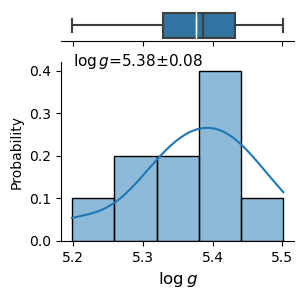

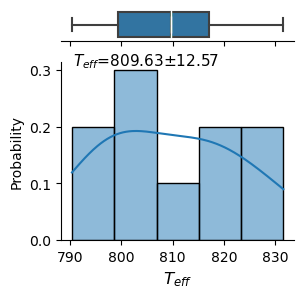

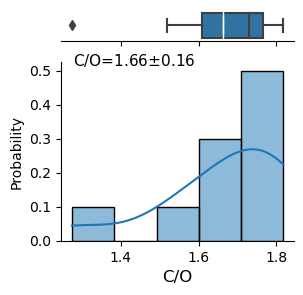

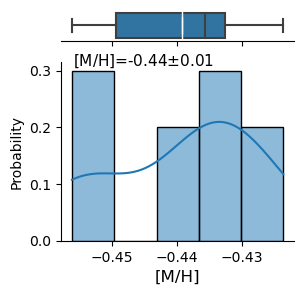

In [77]:
df_random_pred = PredictObsParametersRegression2(object_name = 'GJ570D', #Ross458C, HD3651B, GJ570D
                                                predict_from_random_spectra = True,
                                                random_spectra_num=10,
                                                print_results = False,
                                                plot_randomly_generated_spectra = True, 
                                                print_df_describe = False,
                                                plot_histogram = False, 
                                                plot_observational_spectra_errorbar = True,
                                                plot_boxplot_hist = True,
                                                plot_predicted_vs_observed_ = True

                                                            )

---

# HD3651B

Loading BokehJS ...

[[ 5.3088269e+00  1.6744713e+00 -4.6002612e-01  8.0781946e+02]]
<built-in method values of dict object at 0x7f7fd66b43c0>
5.25
1.5
-0.5
800


,logg,c_o,met,T
count,20.000000,20.000000,20.000000,20.000000
mean,5.327493,1.847984,-0.441292,798.605286
std,0.097924,0.152614,0.015609,21.898378
min,5.077450,1.603621,-0.469353,754.943848
25%,5.276865,1.739578,-0.452944,781.442520
50%,5.337498,1.832603,-0.441701,804.128510
75%,5.369240,1.989236,-0.426843,813.188477
max,5.570023,2.083487,-0.412026,832.126526


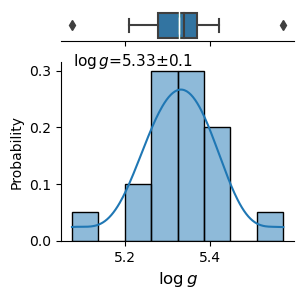

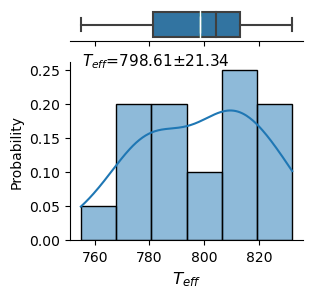

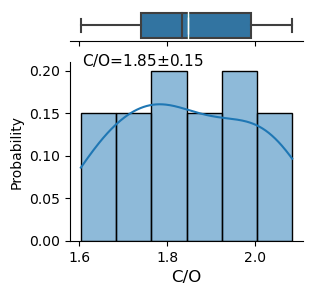

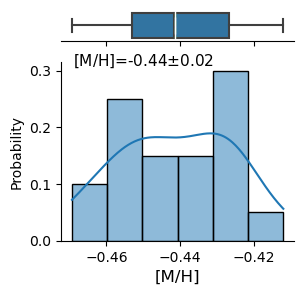

In [75]:
df_random_pred = PredictObsParametersRegression2(object_name = 'HD3651B', #Ross458C, HD3651B, GJ570D
                                                predict_from_random_spectra = True,
                                                random_spectra_num=20,
                                                print_results = False,
                                                plot_randomly_generated_spectra = True, 
                                                print_df_describe = False,
                                                plot_histogram = False, 
                                                plot_observational_spectra_errorbar = True,
                                                plot_boxplot_hist = True,
                                                plot_predicted_vs_observed_ = True

                                                            )

---

# Ross458C

Loading BokehJS ...

[[ 2.3285718e+00  2.1975067e+00 -6.4727837e-01  7.0950775e+02]]
<built-in method values of dict object at 0x7f7fd5cac380>
3.0
2.0
-0.7
700


,logg,c_o,met,T
count,20.000000,20.000000,20.000000,20.000000
mean,1.678352,2.314560,-0.759735,854.694458
std,0.384814,0.351985,0.188198,122.825363
min,0.890464,1.610678,-0.982053,702.736816
25%,1.502563,2.201035,-0.856089,743.109177
50%,1.695928,2.389312,-0.808940,838.631134
75%,1.921259,2.525322,-0.731444,992.013153
max,2.442073,2.932632,-0.103837,1061.689819


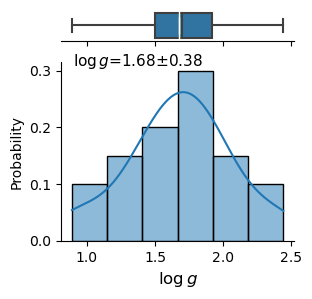

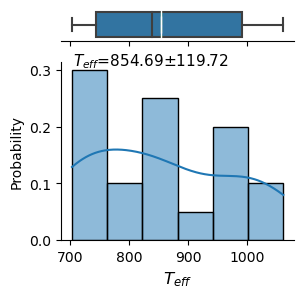

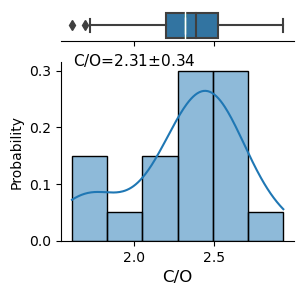

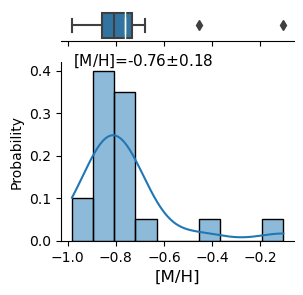

In [78]:
df_random_pred = PredictObsParametersRegression2(object_name = 'Ross458C', #Ross458C, HD3651B, GJ570D
                                                predict_from_random_spectra = True,
                                                random_spectra_num=20,
                                                print_results = False,
                                                plot_randomly_generated_spectra = True, 
                                                print_df_describe = False,
                                                plot_histogram = False, 
                                                plot_observational_spectra_errorbar = True,
                                                plot_boxplot_hist = True,
                                                plot_predicted_vs_observed_ = True

                                                            )

# END ------

# END ------

# END ------

# END ------

## ROSS 458C

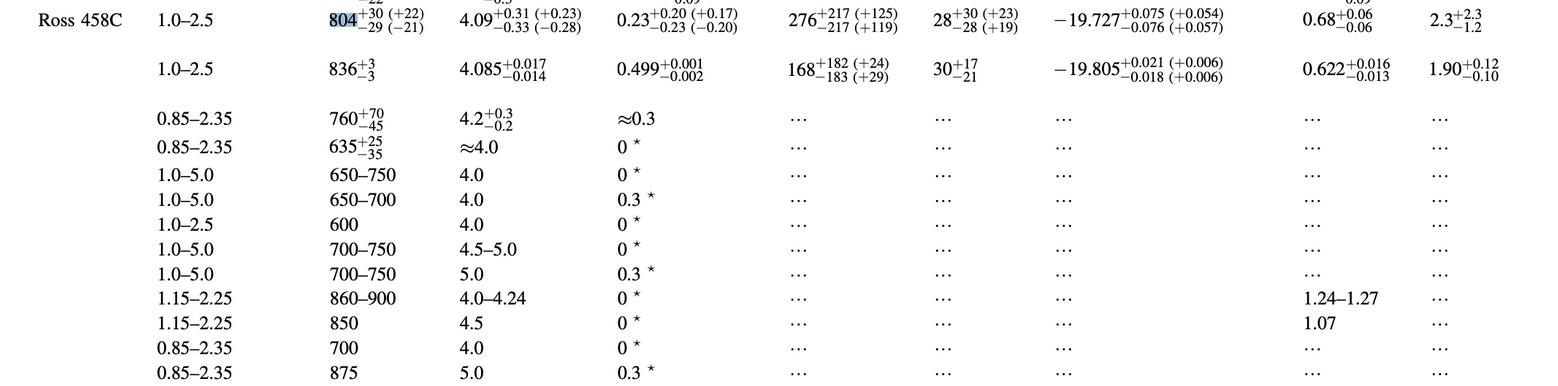

### Load X and y StandardScaler Operators

In [74]:
fluxcal = pd.read_csv(f'../../datasets/observational_spectra/Ross458C_fluxcal.dat', 
                   delim_whitespace=True, comment='#', names=('wl','F_lambda','F_lambda_error'), 
                   usecols=(0,1,2))#.dropna(inplace=True)

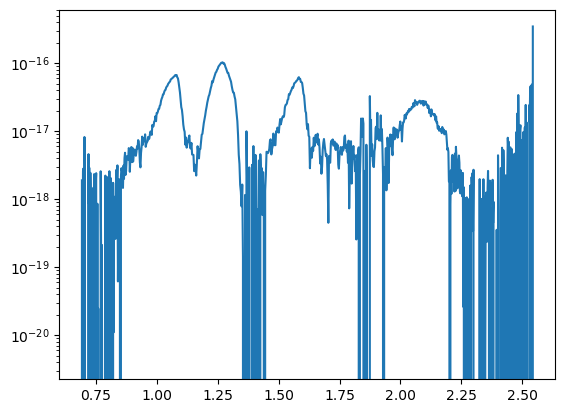

In [75]:
plt.semilogy( fluxcal['wl'],fluxcal['F_lambda'])

In [76]:
fluxcal['F_lambda']=fluxcal['F_lambda'].mask(fluxcal['F_lambda'].lt(0),0)
fluxcal['F_lambda'].replace(0, np.nan, inplace=True)
fluxcal['F_lambda'].interpolate(inplace=True)

In [77]:
bd_object = ProcessObservationalDataset( feature_values_obs = fluxcal['F_lambda'].values,
                                 feature_names_obs  = fluxcal['wl'].values, 
                                 feature_names_synthetic = wl['wl'].values,
                                )

object_name = 'Ross458C'
# add the BD derived values: name, Teff, logg, met, distance_pc, radius_Rjup
if object_name == 'Ross458C':
    bd_object.bd_info('Ross458C','804','4.09','0.23', 11.509, 0.68 )
if object_name == 'HD3651B':
    bd_object.bd_info('HD3651B','818','3.94','-0.22', 11.134, 0.81 )
if object_name == 'GJ570D':
    bd_object.bd_info('GJ570D','818','3.94','-0.22', 5.884, 0.79 )    




bd_object.flux_interpolated(print_results=False, 
                            plot_results=True,
                            use_spectres=True
                           )
bd_object.df_flux_object     

# print(bd_object.df_flux_object[::-1] )

,0.897,0.906,0.915,0.924,0.933,0.943,0.952,0.962,0.971,0.981,...,2.296,2.319,2.342,2.366,2.389,2.413,2.438,2.462,2.487,2.512
0,7.431980e-09,6.772274e-09,7.564100e-09,9.779585e-09,6.589324e-09,1.186165e-08,1.168911e-08,1.217457e-08,1.491817e-08,1.867662e-08,...,1.675178e-08,2.010950e-08,7.911809e-09,1.281873e-08,1.298326e-08,2.857164e-08,4.066384e-08,4.169449e-08,1.412377e-07,1.428379e-07


### Create Min Max features


In [78]:
bd_object.df_flux_object_min = bd_object.df_flux_object.min(axis=1)
bd_object.df_flux_object_max = bd_object.df_flux_object.max(axis=1)

df_MinMax_obs = pd.DataFrame(( bd_object.df_flux_object_min, bd_object.df_flux_object_max)).T

xxx2 = train_cnn_regression.standardize_X_ColumnWise.transform(df_MinMax_obs.values)

xxx2

array([[-0.32487983, -0.44370116]])

### Create normalized X_obs 

X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

X_scaled = X_std * (max - min) + min

In [79]:
X_std = (bd_object.df_flux_object.values[0] - bd_object.df_flux_object.min(axis=1)[0]) / (bd_object.df_flux_object.max(axis=1)[0] - bd_object.df_flux_object.min(axis=1)[0])
X_scaled = X_std * (1. - 0.) + 0.

In [80]:
X_scaled = X_scaled[::-1].reshape(1,104)

In [81]:
y_pred_train = np.array(train_cnn_regression.trained_model.predict([X_scaled,xxx2]) )[:,:,0].T
y_pred_train_ = train_cnn_regression.standardize_y_ColumnWise.inverse_transform( y_pred_train )
y_pred_train_ [:,3] = 10**y_pred_train_[:,3]
y_pred = y_pred_train_

1/1 [==============================] - 0s 197ms/step


In [82]:
y_pred

array([[ 3.8962324e+00,  1.5883893e+00, -5.5495590e-01,  9.0334808e+02]],
      dtype=float32)

In [83]:
import pandas as pd
import numpy as np
nearest_value_list = []

def filter_dataframe(df, targets):
    # Check if the values exist in the respective columns
    for col, value in targets.items():
        if value not in df[col].values:
            # Find the nearest values in the column
            nearest_value = df[col].values[np.argmin(np.abs(df[col].values - value))]
            print(nearest_value)
            targets[col] = nearest_value
            nearest_value_list.append(nearest_value)

    # Filter the DataFrame based on the values
    filtered_df = df
    for col, value in targets.items():
        filtered_df = filtered_df[filtered_df[col] == value]

    return nearest_value_list, filtered_df

# Specify target values
targets = dict ( zip( ['gravity', 'c_o_ratio', 'metallicity', 'temperature'] , [y_pred[0][i] for i in range(4)]) )
# Print the filtered DataFrame

# Filter the DataFrame and get the result
nearest_value1, filtered_df1 = filter_dataframe(df, targets)
display(filtered_df1)


#### ====================================================================================================
#### ====================================================================================================
#### ====================================================================================================
#### ====================================================================================================
#### ====================================================================================================

# Create the figure
p = figure(title='[XNorm, yStand] Predicted: '+', '.join([['logg= ','C/O= ', 'Met= ', 'T= '][i]+str(np.round(y_pred[0][i],2)) for i in  range(4)]), 
           x_axis_label='X', 
           y_axis_label='Y',
           width=1000, height=300,
           y_axis_type = 'log')

# Add the scatter plot
p.line(x =wl['wl'] , y=filtered_df1.iloc[:,4:-1].values[0], 
       line_width = 1,
       legend_label='Modeled:'+', '.join([['logg= ','C/O= ', 'Met= ', 'T= '][i]+str(np.round(nearest_value1[i],2)) for i in  range(4)]))
p.circle(x = wl['wl'] , y=filtered_df1.iloc[:,4:-1].values[0],
       line_width = 2,
       # legend_label='Observation'
        )



p.line(x =wl['wl'] , y=bd_object.df_flux_object.iloc[:, ::-1].values[0],
       line_color = 'orange', line_width = 2,
       legend_label='Observation')

# Increase size of x and y ticks
p.title.text_font_size = '12pt'
p.xaxis.major_label_text_font_size = '12pt'
p.xaxis.axis_label_text_font_size = '12pt'
p.yaxis.major_label_text_font_size = '12pt'
p.yaxis.axis_label_text_font_size = '12pt'

        
p.legend.location = "bottom_right"
p.legend.background_fill_color = 'white'
p.legend.background_fill_alpha = 0.5
        
        # Add the error bars using vbar
# p.vbar('x_err', top='upper', bottom='lower', width=0.001, source=source, line_color='grey')

# Show the plot
show(p)

4.0
1.5
-0.5
900


,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897,is_augmented
4286,4.0,900,1.5,-0.5,2.355304e-08,2.359675e-08,1.726787e-08,1.172866e-08,9.852254e-09,5.767140e-09,...,3.711211e-08,2.813999e-08,2.722816e-08,2.446291e-08,1.594422e-08,2.145603e-08,1.953185e-08,1.488883e-08,8.673812e-09,no


In [85]:
import pandas as pd
import numpy as np

def filter_dataframe(df, targets):
    # Check if the values exist in the respective columns
    for col, value in targets.items():
        if value not in df[col].values:
            # Find the nearest values in the column
            nearest_value = df[col].values[np.argmin(np.abs(df[col].values - value))]
            print(nearest_value)
            targets[col] = nearest_value

    # Filter the DataFrame based on the values
    filtered_df = df
    for col, value in targets.items():
        filtered_df = filtered_df[filtered_df[col] == value]

    return filtered_df

# Specify target values
targets = dict ( zip( ['gravity', 'c_o_ratio', 'metallicity', 'temperature'] , [y_pred[0][i] for i in range(4)]) )
# Print the filtered DataFrame

# Filter the DataFrame and get the result
filtered_df1 = filter_dataframe(df, targets)
display(filtered_df1)

targets = dict ( zip( ['gravity', 'c_o_ratio', 'metallicity', 'temperature'] , [4, 1, 0, 900]) )
filtered_df2 = filter_dataframe(df, targets)
# display(filtered_df2)


4.0
1.5
-0.5
900


,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897,is_augmented
4286,4.0,900,1.5,-0.5,2.355304e-08,2.359675e-08,1.726787e-08,1.172866e-08,9.852254e-09,5.767140e-09,...,3.711211e-08,2.813999e-08,2.722816e-08,2.446291e-08,1.594422e-08,2.145603e-08,1.953185e-08,1.488883e-08,8.673812e-09,no


In [44]:
fluxcal

,wl,F_lambda,F_lambda_error
0,0.650857,8.606238e-17,4.358173e-17
1,0.653073,1.771977e-17,3.360256e-17
2,0.655278,7.300979e-17,3.132892e-17
3,0.657472,2.569511e-17,2.837585e-17
4,0.659659,3.786160e-18,2.497690e-17
...,...,...,...
559,2.550960,6.071953e-18,3.190524e-17
560,2.553900,1.090368e-17,3.022278e-17
561,2.556850,1.573540e-17,2.389914e-17
562,2.559820,1.129194e-17,1.702191e-17


In [86]:
# from bokeh.plotting import figure, show
# from bokeh.models import ColumnDataSource


# # Create a ColumnDataSource to store the data
# source = ColumnDataSource(data=dict(x=, y=, error=fluxcal['F_lambda_error']))

from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
import numpy as np

# Sample data
x = fluxcal['wl']
y = fluxcal['F_lambda']
error = fluxcal['F_lambda_error']

# Calculate the error bar coordinates
x_err = x
y_err = y
upper = [y_val + err_val for y_val, err_val in zip(y, error)]
lower = [y_val - err_val for y_val, err_val in zip(y, error)]

# Create a ColumnDataSource to store the data
source = ColumnDataSource(data=dict(x=x, y=y, x_err=x_err, y_err=y_err, upper=upper, lower=lower))

# Create the figure
p = figure(title='Scatter Plot with Error Bars', 
           x_axis_label='X', 
           y_axis_label='Y',
           width=800, height=300,
           y_axis_type = 'log')

# Add the scatter plot
p.scatter('x', 'y', source=source, legend_label='Data')

# Add the error bars using vbar
p.vbar('x_err', top='upper', bottom='lower', width=0.001, source=source, line_color='grey')

# Show the plot
show(p)


In [87]:
filtered_df1.iloc[:,4:-1]

,2.512,2.487,2.462,2.438,2.413,2.389,2.366,2.342,2.319,2.296,...,0.981,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897
4286,2.355304e-08,2.359675e-08,1.726787e-08,1.172866e-08,9.852254e-09,5.767140e-09,4.539271e-09,2.609292e-09,4.864006e-09,2.847503e-09,...,4.771327e-08,3.711211e-08,2.813999e-08,2.722816e-08,2.446291e-08,1.594422e-08,2.145603e-08,1.953185e-08,1.488883e-08,8.673812e-09


In [88]:
# Create the figure
p = figure(title='Scatter Plot with Error Bars', 
           x_axis_label='X', 
           y_axis_label='Y',
           width=800, height=300,
           y_axis_type = 'log')

# Add the scatter plot
p.line(x =wl['wl'] , y=filtered_df1.iloc[:,4:-1].values[0], 
       line_width = 1,
       legend_label='Modeled')
p.circle(x = wl['wl'] , y=filtered_df1.iloc[:,4:-1].values[0],
       line_width = 2,
       # legend_label='Observation'
        )



p.line(x =wl['wl'] , y=bd_object.df_flux_object.iloc[:, ::-1].values[0],
       line_color = 'orange', line_width = 2,
       legend_label='Observation')

# Add the error bars using vbar
# p.vbar('x_err', top='upper', bottom='lower', width=0.001, source=source, line_color='grey')

# Show the plot
show(p)

In [90]:
import random
from bokeh.palettes import Magma, Inferno, Plasma, Viridis, Cividis
from bokeh.palettes import  viridis, inferno
       

    
def PredictObsParametersRegression2(object_name, 
                                    predict_from_random_spectra = True,
                                    random_spectra_num=10,
                                    print_results = False,
                                    plot_results = False,
                                    print_df_describe = False,
                                    plot_histogram = False,
                                   ):


    spectra_list = []
    param_list = []    
    color = viridis(100).__iter__()


    fluxcal = pd.read_csv(f'../../datasets/observational_spectra/{object_name}_fluxcal.dat', 
                       delim_whitespace=True, comment='#', names=('wl','F_lambda','F_lambda_error'), 
                       usecols=(0,1,2))#.dropna(inplace=True)

    fluxcal['F_lambda']=fluxcal['F_lambda'].mask(fluxcal['F_lambda'].lt(0),0)
    fluxcal['F_lambda'].replace(0, np.nan, inplace=True)
    fluxcal['F_lambda'].interpolate(inplace=True)

    bd_object = ProcessObservationalDataset( feature_values_obs = fluxcal['F_lambda'].values,
                                     feature_names_obs  = fluxcal['wl'].values, 
                                     feature_names_synthetic = wl['wl'].values,
                                    )

    # add the BD derived values: name, Teff, logg, met, distance_pc, radius_Rjup
    if object_name == 'Ross458C':
        bd_object.bd_info('Ross458C','804','4.09','0.23', 11.509, 0.68 )
    if object_name == 'HD3651B':
        bd_object.bd_info('HD3651B','818','3.94','-0.22', 11.134, 0.81 )
    if object_name == 'GJ570D':
        bd_object.bd_info('GJ570D','818','3.94','-0.22', 5.884, 0.79 )    




    bd_object.flux_interpolated(print_results=False, 
                                plot_results=True,
                                use_spectres=True
                               )
    bd_object.df_flux_object     


    
    # ********************************* 
    bd_object.df_flux_object_min = bd_object.df_flux_object.min(axis=1)
    bd_object.df_flux_object_max = bd_object.df_flux_object.max(axis=1)

    df_MinMax_obs = pd.DataFrame(( bd_object.df_flux_object_min, bd_object.df_flux_object_max)).T

    xxx2 = train_cnn_regression.standardize_X_ColumnWise.transform(df_MinMax_obs.values)


    X_std = (bd_object.df_flux_object.values[0] - bd_object.df_flux_object.min(axis=1)[0]) / (bd_object.df_flux_object.max(axis=1)[0] - bd_object.df_flux_object.min(axis=1)[0])
    X_scaled = X_std * (1. - 0.) + 0.
    #     bd_mean = bd_object.df_flux_object.mean(axis=1)[0]  
    #     bd_std = bd_object.df_flux_object.std(axis=1)[0]     

    #     X_scaled = (bd_object.df_flux_object.values[0] - bd_mean) / bd_std

    y_pred_train = np.array(train_cnn_regression.trained_model.predict([X_scaled[::-1].reshape(1,104),xxx2]) )[:,:,0].T
    y_pred_train_ = train_cnn_regression.standardize_y_ColumnWise.inverse_transform( y_pred_train )
    y_pred_train_ [:,3] = 10**y_pred_train_[:,3]
    y_pred = y_pred_train_
    # ********************************* 
            
    #     xxx = train_cnn_regression.standardize_X_ColumnWise.transform( bd_object.df_flux_object.iloc[:, ::-1] )

    #     y_pred_train = np.array(train_cnn_regression.trained_model.predict(xxx) )[:,:,0].T
    #     y_pred_train_ = train_cnn_regression.standardize_y_ColumnWise.inverse_transform( y_pred_train )
    #     y_pred_train_ [:,3] = 10**y_pred_train_[:,3]
    #     y_pred = y_pred_train_       
        
        
        
    if predict_from_random_spectra:
        for i in range(random_spectra_num):
            spectra = pd.DataFrame( [random.uniform(fluxcal.F_lambda[i]-1*fluxcal.F_lambda_error[i], 
                                 fluxcal.F_lambda[i]+1*fluxcal.F_lambda_error[i]) 
                                 for i in range(len(fluxcal))],columns=['F_lambda'] )



            # Process the dataset
            spectra['F_lambda'] = spectra['F_lambda'].mask(spectra['F_lambda'].lt(0),0)
            spectra['F_lambda'].replace(0, np.nan, inplace=True)
            spectra['F_lambda'].interpolate(inplace=True)


            # Instintiate Process Observational Dataset class
            bd_object_generated = ProcessObservationalDataset( feature_values_obs = spectra['F_lambda'].values,
                                             feature_names_obs  = fluxcal['wl'].values, 
                                             feature_names_synthetic = wl['wl'].values,
                                            )


            # add the BD derived values: name, Teff, logg, met, distance_pc, radius_Rjup
            if object_name == 'Ross458C':
                bd_object_generated.bd_info('Ross458C','804','4.09','0.23', 11.509, 0.68 )
            if object_name == 'HD3651B':
                bd_object_generated.bd_info('HD3651B','818','3.94','-0.22', 11.134, 0.81 )
            if object_name == 'GJ570D':
                bd_object_generated.bd_info('GJ570D','818','3.94','-0.22', 5.884, 0.79 )    
    



            bd_object_generated.flux_interpolated(print_results=False, 
                                        plot_results=False,
                                        use_spectres=True
                                       )
            bd_object_generated.df_flux_object    
    
            # bd_object_generated.flux_interpolated(print_results=False, plot_results=False)
            # bd_object_generated.df_flux_object.values
            spectra_list.append(bd_object_generated.df_flux_object.values)
            
            # ********************************* 
            bd_object_generated.df_flux_object_min = bd_object_generated.df_flux_object.min(axis=1)
            bd_object_generated.df_flux_object_max = bd_object_generated.df_flux_object.max(axis=1)

            df_MinMax_obs = pd.DataFrame(( bd_object_generated.df_flux_object_min, bd_object_generated.df_flux_object_max)).T

            xxx2 = train_cnn_regression.standardize_X_ColumnWise.transform(df_MinMax_obs.values)

            
            X_std = (bd_object_generated.df_flux_object.values[0] - bd_object_generated.df_flux_object.min(axis=1)[0]) / (bd_object_generated.df_flux_object.max(axis=1)[0] - bd_object.df_flux_object.min(axis=1)[0])
            X_scaled = X_std * (1. - 0.) + 0.

            # bd_mean = bd_object_generated.df_flux_object.mean(axis=1)[0]  
            # bd_std = bd_object_generated.df_flux_object.std(axis=1)[0]     

            # X_scaled = (bd_object_generated.df_flux_object.values[0] - bd_mean) / bd_std

            y_pred_train = np.array(train_cnn_regression.trained_model.predict([X_scaled[::-1].reshape(1,104),xxx2]) )[:,:,0].T
            y_pred_train_ = train_cnn_regression.standardize_y_ColumnWise.inverse_transform( y_pred_train )
            y_pred_train_ [:,3] = 10**y_pred_train_[:,3]
            y_pred = y_pred_train_
            # ********************************* 


#             xxx = train_cnn_regression.standardize_X_ColumnWise.transform( bd_object_generated.df_flux_object.iloc[:, ::-1] )

#             y_pred_train = np.array(train_cnn_regression.trained_model.predict(xxx) )[:,:,0].T
#             y_pred_train_ = train_cnn_regression.standardize_y_ColumnWise.inverse_transform( y_pred_train )
#             y_pred_train_ [:,3] = 10**y_pred_train_[:,3]
#             y_pred = y_pred_train_    
            
            # print(y_pred)
    
    
            param_list.append(  y_pred[0] )

        df_random_pred = pd.DataFrame(param_list, columns=['logg' ,'c_o' ,'met' ,'T'] )
        display(df_random_pred.describe())
            
        if print_results:
            print(param_list)

        if plot_results:
            p = figure(title="Randomly generated spectra in 1σ", 
                       x_axis_label='features [wavelengths]', y_axis_label='Flux (Fν)',
                       width=800, height=300,
                       y_axis_type="log", background_fill_color="#fafafa"
                      )
            

            for i in range(0,random_spectra_num,int(1)):
                    p.line(wl.wl.values,spectra_list[i][0], 
                           line_width = 1,
                           line_alpha = 0.6, 
                           line_color=next(color),
                           )
            show(p)

            
        if print_df_describe:
            display(df_random_pred.describe())
            
            
        if plot_histogram:
            plt.figure()
            df_random_pred.hist()
            plt.show()
            

    return df_random_pred

        

            
            

In [91]:
df_random_pred = PredictObsParametersRegression2(object_name = 'Ross458C', 
                                                predict_from_random_spectra = True,
                                                random_spectra_num=100,
                                                print_results = False,
                                                plot_results = True,
                                                print_df_describe = False,
                                                plot_histogram = False, 
                                                            )

1/1 [==============================] - 0s 126ms/step


,logg,c_o,met,T
count,100.000000,100.000000,100.000000,100.000000
mean,3.877156,1.840562,-0.410838,917.102783
std,0.194261,0.246731,0.154425,25.090284
min,3.447235,1.351300,-0.657240,860.413391
25%,3.750992,1.638820,-0.524204,902.026062
50%,3.877228,1.800155,-0.437623,917.118561
75%,4.021253,2.011322,-0.337315,932.021591
max,4.319098,2.364101,0.024382,972.315125


In [92]:
def boxplot_hist(data, x_label, xy_loc):
    
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    
    sns.histplot(data, ax=ax_hist, kde=True, stat='probability')
    sns.boxplot(x = data, ax=ax_box, showmeans=True, meanline = True,
                meanprops={"marker": "|",
                           "markeredgecolor": "white",
                           "markersize": "30", 
                            }
                       )
    
    fig.set_figheight(3)
    fig.set_figwidth(3)

    ax_box.set(xlabel='')
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    ax_box.set_yticks([])

    mean = np.round(np.mean(data),1)
    std = np.round(np.std(data),1)
    plt.annotate(f'{x_label}='+str(np.round(mean,2))+'$\pm$'+str(np.round(std,2)), fontsize=11, 
                 xy=(xy_loc[0], xy_loc[1]), xycoords='axes fraction')
                    
    plt.xlabel(x_label, fontsize = 12)

    plt.show()

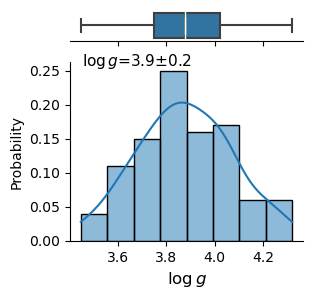

In [93]:
boxplot_hist(df_random_pred['logg'],  x_label=r'$\log g$', xy_loc=[0.05,0.98],)

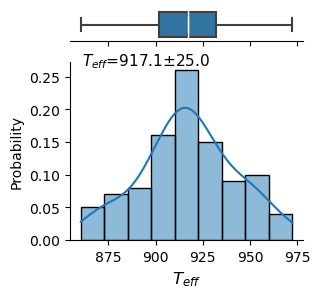

In [94]:
boxplot_hist(df_random_pred['T'],x_label=r'$T_{eff}$', xy_loc=[0.05,0.98],)

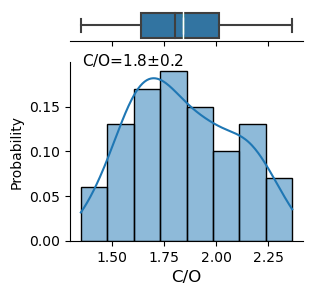

In [95]:
boxplot_hist(df_random_pred['c_o'], x_label=r'C/O', xy_loc=[0.05,0.98],)

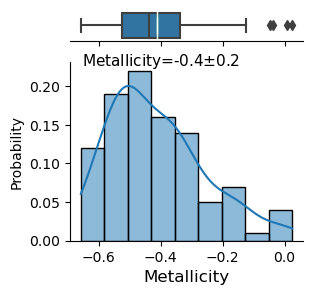

In [96]:
boxplot_hist(df_random_pred['met'], x_label=r'Metallicity', xy_loc=[0.05,0.98],)

---

## HD3651B

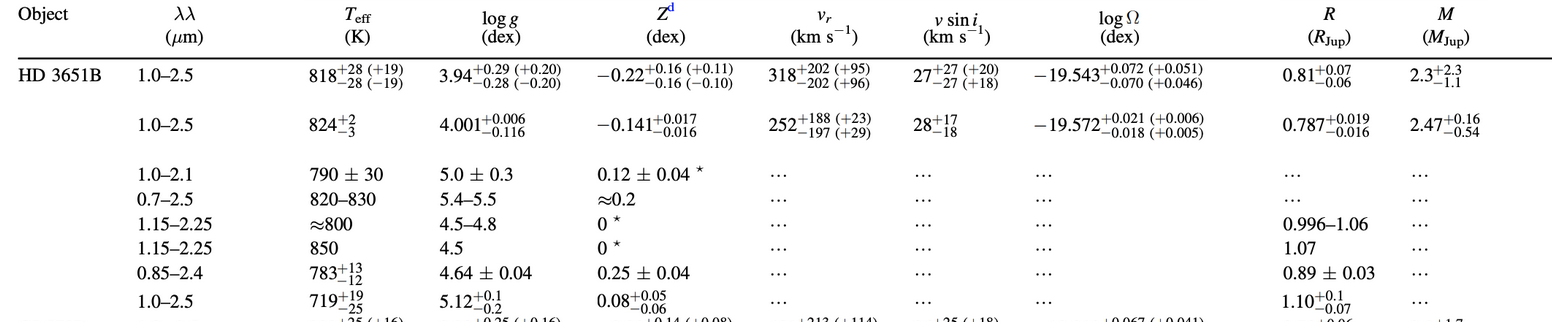

In [130]:
# plt.semilogy( df[df['temperature']==800].drop(columns=['gravity','temperature','c_o_ratio','metallicity','is_augmented']));

In [529]:
df_random_pred = PredictObsParametersRegression2(object_name = 'HD3651B', 
                                                predict_from_random_spectra = True,
                                                random_spectra_num=100,
                                                print_results = False,
                                                plot_results = True,
                                                print_df_describe = False,
                                                plot_histogram = False, 
                                                            )

1/1 [==============================] - 0s 125ms/step


,logg,c_o,met,T
count,100.000000,100.000000,100.000000,100.000000
mean,4.857421,1.410336,-0.713726,808.738342
std,0.064556,0.055257,0.048653,7.695847
min,4.695873,1.248216,-0.824881,791.412537
25%,4.812944,1.378087,-0.749184,803.610107
50%,4.861358,1.420396,-0.713367,808.425018
75%,4.904747,1.447242,-0.673975,814.355209
max,5.022175,1.549816,-0.614226,829.947632


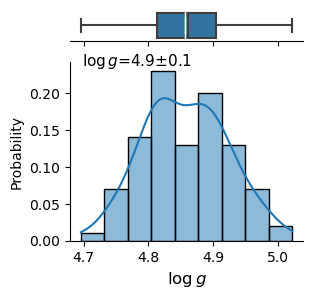

In [530]:
boxplot_hist(df_random_pred['logg'],  x_label=r'$\log g$', xy_loc=[0.05,0.98],)

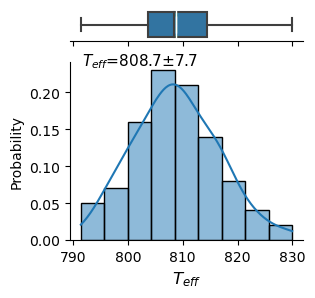

In [531]:
boxplot_hist(df_random_pred['T'],x_label=r'$T_{eff}$', xy_loc=[0.05,0.98],)

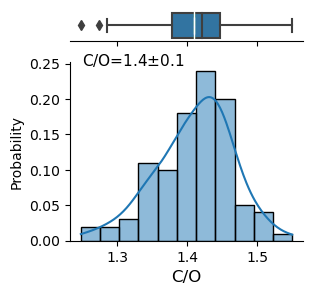

In [532]:
boxplot_hist(df_random_pred['c_o'], x_label=r'C/O', xy_loc=[0.05,0.98],)

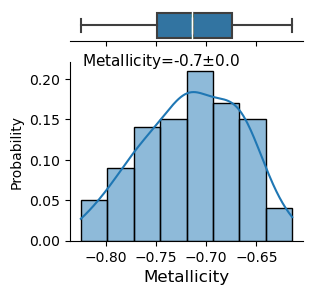

In [533]:
boxplot_hist(df_random_pred['met'], x_label=r'Metallicity', xy_loc=[0.05,0.98],)

---

# Step 5: tensorflow_probability

In [114]:
import tensorflow_probability as tfp

def function_factory(model, loss, train_x, train_y, test_x, test_y):
    """A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a function with signature loss_value = loss(pred_y, true_y).
        train_x [in]: the input part of training data.
        train_y [in]: the output part of training data.
        ## DP addition:
        test_x [in]: the input part of test data (just for metric purposes)
        test_y [in]: the output part of test data (just for metric purposes)
    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    # obtain the shapes of all trainable parameters in the model
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)

    # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
    # prepare required information first
    count = 0
    idx = [] # stitch indices
    part = [] # partition indices

    for i, shape in enumerate(shapes):
        n = np.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n

    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function updating the model's parameters with a 1D tf.Tensor.
        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """

        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    # now create a function that will be returned by this factory
    @tf.function
    def f(params_1d):
        """A function that can be used by tfp.optimizer.lbfgs_minimize.
        This function is created by function_factory.
        Args:
           params_1d [in]: a 1D tf.Tensor.
        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """

        # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
        with tf.GradientTape() as tape:
            # update the parameters in the model
            assign_new_model_parameters(params_1d)
            # calculate the loss
            loss_value = loss(model(train_x, training=True), train_y)
            

        # calculate gradients and convert to 1D tf.Tensor
        grads = tape.gradient(loss_value, model.trainable_variables)
        grads = tf.dynamic_stitch(idx, grads)

        # print out iteration & loss
        f.iter.assign_add(1)
        test_loss=loss(model(test_x), test_y)
        tf.print("Iter:", f.iter, "loss:", loss_value, "test loss:", test_loss)

        # store loss and test_loss values so we can retrieve later
        tf.py_function(f.history.append, inp=[[loss_value, test_loss]], Tout=[])

        return loss_value, grads

    # store these information as members so we can use them outside the scope
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.history = []

    return f

In [ ]:
cnn_model

In [115]:
##### TRAIN MODEL WITH L-BFGS optimizer ##########

## Define the type of loss function we want to use
loss_fun = tf.keras.losses.Huber()

## Create a function that agregates our cnn model, etc to pass it to the optimizer
func = function_factory(cnn_model.trained_model, loss_fun, 
                            [cnn_model.X_train.astype(np.float32), cnn_model.X2_train.astype(np.float32)], cnn_model.y_train.astype(np.float32),
                            [cnn_model.X_test.astype(np.float32), cnn_model.X2_test.astype(np.float32)],
                            cnn_model.y_test.astype(np.float32),)
                        # x_train_scaled_rowcol, y_train, x_test_scaled_rowcol, y_test)

## Convert initial model parameters to a 1D tf.Tensor
init_params = tf.dynamic_stitch(func.idx, cnn_model.trained_model.trainable_variables)

## Train the model with L-BFGS solver
results = tfp.optimizer.lbfgs_minimize(value_and_gradients_function=func, \
                                       initial_position=init_params, max_iterations=100)

## After training, the final optimized parameters are still in results.position
## so we have to manually put them back to the model
func.assign_new_model_parameters(results.position)

NameError: name 'cnn_model' is not defined

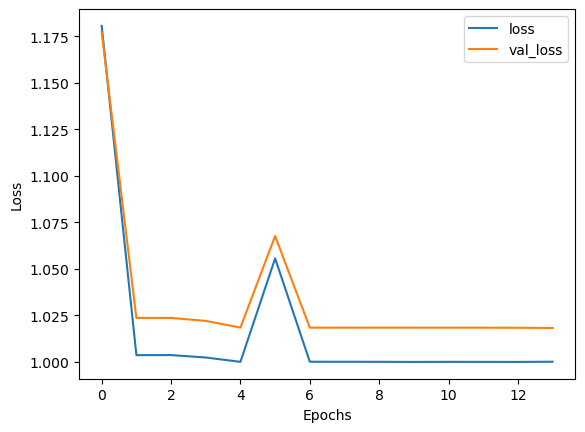

In [26]:
## If you used Livelossplot, you can skip this. Otherwise we can take a look at the training process by plotting the
## models history.
plt.plot(np.array( func.history )[2:,0], label='loss')
plt.plot(np.array( func.history )[2:,1], label='val_loss')
plt.yscale('linear')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
## In case you used ReduceLROnPlateau() you can plot the lr as well
# ax2 = plt.gca().twinx()
# ax2.plot(h1.history['lr'], color='r')
# ax2.set_ylabel('lr',color='r')
# plt.ylim((1e-2,0.1))
plt.show()

In [49]:
cnn_model.trained_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 104, 1)]     0           []                               
                                                                                                  
 input1-Scaled (Conv1D)         (None, 35, 5)        50          ['input_3[0][0]']                
                                                                                                  
 Conv1D_layer1 (Conv1D)         (None, 35, 68)       19108       ['input1-Scaled[0][0]']          
                                                                                                  
 MaxPooling1D_layer1 (MaxPoolin  (None, 7, 68)       0           ['Conv1D_layer1[0][0]']          
 g1D)                                                                                       

In [63]:
# cnn_model.trained_model.trainable_variables

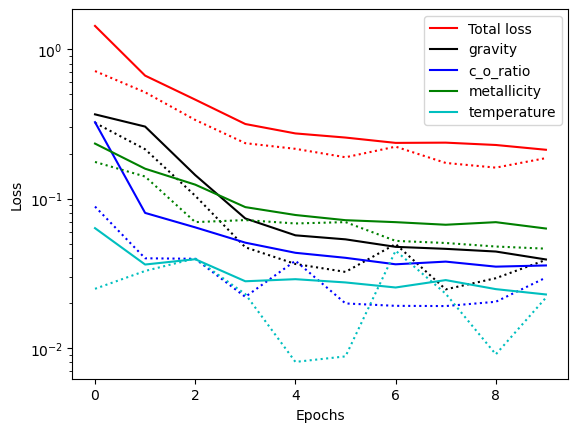

In [27]:
## If you used Livelossplot, you can skip this. Otherwise we can take a look at the training process by plotting the
## models history.
plt.plot(trained_cnn_model['history'].history['loss'], 'r-',label='Total loss')
plt.plot(trained_cnn_model['history'].history['val_loss'], 'r:')

plt.plot(trained_cnn_model['history'].history['gravity_loss'], 'k-',label='gravity')
plt.plot(trained_cnn_model['history'].history['val_gravity_loss'], 'k:')

plt.plot(trained_cnn_model['history'].history['c_o_ratio_loss'], 'b-',label='c_o_ratio')
plt.plot(trained_cnn_model['history'].history['val_c_o_ratio_loss'], 'b:')


plt.plot(trained_cnn_model['history'].history['metallicity_loss'], 'g-',label='metallicity')
plt.plot(trained_cnn_model['history'].history['val_metallicity_loss'], 'g:')

plt.plot(trained_cnn_model['history'].history['temperature_loss'], 'c-',label='temperature')
plt.plot(trained_cnn_model['history'].history['val_temperature_loss'], 'c:', )


plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
## In case you used ReduceLROnPlateau() you can plot the lr as well
# ax2 = plt.gca().twinx()
# ax2.plot(h1.history['lr'], color='r')
# ax2.set_ylabel('lr',color='r')
plt.show();